In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
from scipy.linalg import sqrtm 
import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.multivariate_normal import CensoredMultivariateNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, cov
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

TABLE_NAME = 'logs'

In [135]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/multi_censor_',
    'exp': 'multiCensoredVaryingVar', 
    'trials': 20,
    'var': 10,
    'd': 2,
})

Synthetic Data Experiment for 2 Dimensional Censored Gaussian Distributions 

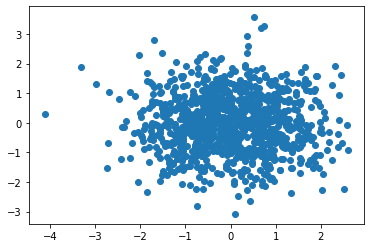

In [3]:
M = MultivariateNormal(ch.zeros(2), ch.eye(2))
samples = M.sample([args.samples])

plt.scatter(samples[:,0], samples[:,1])
plt.show()

Truncate the Dataset

alpha: 0.412


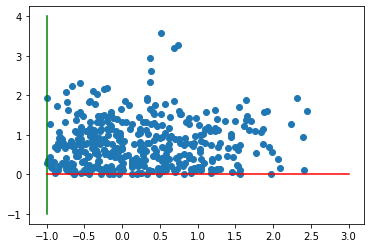

In [111]:
# phi = oracle.Left(Tensor([-float('inf'), 0]))
phi = oracle.Left(Tensor([-1, 0]))

indices = phi(samples).nonzero(as_tuple=False).flatten()
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))
plt.plot(phi.left[0].repeat(100, 1), ch.linspace(-1, 4, 100), color='green')
plt.plot(ch.linspace(-1, 3, 100), phi.left[1].repeat(100, 1), color='red')

plt.scatter(S[:,0], S[:,1])
plt.show()

In [112]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_cov = cov(S)
print("empirical covariance: ", emp_cov)
emp_scale = Tensor(sqrtm(emp_cov.numpy()))

S_norm = (S - emp_loc)@Tensor(sqrtm(emp_cov.numpy())).inverse()
phi_norm = oracle.Left((phi.left - emp_loc)@Tensor(sqrtm(emp_cov.numpy())).inverse())

empirical mean:  tensor([0.2261, 0.7672])
empirical covariance:  tensor([[0.5894, 0.0237],
        [0.0237, 0.3586]])


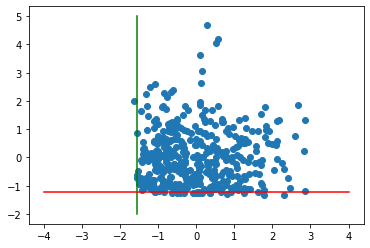

In [113]:
plt.scatter(S_norm[:,0], S_norm[:,1])
plt.plot(phi_norm.left[0].repeat(100, 1), ch.linspace(-2, 5, 100), color='green')
plt.plot(ch.linspace(-4, 4, 100), phi_norm.left[1].repeat(100, 1), color='red')

Run algorithm to Remove Bias from the Dataset

In [126]:
censored_multi = CensoredMultivariateNormal(phi=phi_norm, 
                                            alpha=alpha,
                                            bs=10,
                                            num_samples=1000,
                                            iter_=10, 
                                            step_lr=1500, 
                                            step_lr_gamma=.95)
censored_multi.fit(S_norm)

mu: tensor([0.0334, 0.0136])
cov: tensor([[ 1.0002, -0.0053],
        [-0.0053,  1.0114]])
num samples:  tensor(831)
cov grad: tensor([[ 0.7462,  0.3161],
        [ 0.3161, -0.0984]])
loc grad: tensor([-0.5321,  0.4283])
cov matrix before projection: tensor([[ 0.9252, -0.0263],
        [-0.0263,  0.9986]], requires_grad=True)
cov eigenvalues: tensor([0.9168+0.j, 1.0071+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9986, 0.0263],
        [0.0263, 0.9252]], requires_grad=True)
mu: tensor([ 0.0877, -0.0341])
cov: tensor([[ 1.0021, -0.0285],
        [-0.0285,  1.0816]])
num samples:  tensor(851)
cov grad: tensor([[ 0.2663, -0.4804],
        [-0.4804,  0.1641]])
loc grad: tensor([-0.0986,  0.1935])
cov matrix before projection: tensor([[0.9720, 0.0744],
        [0.0744, 0.9088]], requires_grad=True)
cov eigenvalues: tensor([1.0212+0.j, 0.8596+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9720, 0.0744],
        [0.0744, 0.9088]], re

cov grad: tensor([[-0.6250,  0.2646],
        [ 0.2646,  0.0566]])
loc grad: tensor([ 0.9420, -0.4965])
cov matrix before projection: tensor([[ 0.8402, -0.0084],
        [-0.0084,  0.3759]], requires_grad=True)
cov eigenvalues: tensor([0.8403+0.j, 0.3758+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8402, -0.0084],
        [-0.0084,  0.3759]], requires_grad=True)
mu: tensor([-0.3136, -1.3125])
cov: tensor([[1.1905, 0.0265],
        [0.0265, 2.6606]])
num samples:  tensor(444)
cov grad: tensor([[ 0.0934,  0.2024],
        [ 0.2024, -0.1991]])
loc grad: tensor([-0.2308,  0.5753])
cov matrix before projection: tensor([[ 0.8308, -0.0286],
        [-0.0286,  0.3958]], requires_grad=True)
cov eigenvalues: tensor([0.8327+0.j, 0.3940+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8308, -0.0286],
        [-0.0286,  0.3958]], requires_grad=True)
mu: tensor([-0.3246, -1.4086])
cov: tensor([[1.2066, 0.0872],
        [0.0872, 2.5326]])
nu

cov matrix before projection: tensor([[0.5743, 0.0825],
        [0.0825, 0.3853]], requires_grad=True)
cov eigenvalues: tensor([0.6053+0.j, 0.3543+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5743, 0.0825],
        [0.0825, 0.3853]], requires_grad=True)
mu: tensor([-0.0642, -1.4477])
cov: tensor([[ 1.7966, -0.3848],
        [-0.3848,  2.6780]])
num samples:  tensor(369)
cov grad: tensor([[-0.1135,  0.4359],
        [ 0.4359, -0.0999]])
loc grad: tensor([ 0.0598, -0.1879])
cov matrix before projection: tensor([[0.5856, 0.0389],
        [0.0389, 0.3953]], requires_grad=True)
cov eigenvalues: tensor([0.5933+0.j, 0.3876+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5856, 0.0389],
        [0.0389, 0.3953]], requires_grad=True)
mu: tensor([-0.1869, -1.3586])
cov: tensor([[ 1.7188, -0.1693],
        [-0.1693,  2.5467]])
num samples:  tensor(415)
cov grad: tensor([[ 0.4116,  0.1437],
        [ 0.1437, -0.2018]])
loc grad: tensor([-0.

num samples:  tensor(341)
cov grad: tensor([[-0.0536, -0.2438],
        [-0.2438,  0.0802]])
loc grad: tensor([ 0.5643, -0.4655])
cov matrix before projection: tensor([[0.7367, 0.0302],
        [0.0302, 0.2175]], requires_grad=True)
cov eigenvalues: tensor([0.7385+0.j, 0.2158+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7367, 0.0302],
        [0.0302, 0.2175]], requires_grad=True)
mu: tensor([-0.5126, -1.4002])
cov: tensor([[ 1.3651, -0.1895],
        [-0.1895,  4.6234]])
num samples:  tensor(374)
cov grad: tensor([[-0.1566,  0.1521],
        [ 0.1521, -2.2013]])
loc grad: tensor([-0.0786,  1.5958])
cov matrix before projection: tensor([[0.7524, 0.0150],
        [0.0150, 0.4377]], requires_grad=True)
cov eigenvalues: tensor([0.7531+0.j, 0.4369+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7524, 0.0150],
        [0.0150, 0.4377]], requires_grad=True)
mu: tensor([-0.5262, -1.0779])
cov: tensor([[ 1.3300, -0.0455],
        [-0.0

cov matrix before projection: tensor([[ 0.6512, -0.0048],
        [-0.0048,  0.3212]], requires_grad=True)
cov eigenvalues: tensor([0.6513+0.j, 0.3211+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6512, -0.0048],
        [-0.0048,  0.3212]], requires_grad=True)
mu: tensor([-0.4027, -1.8751])
cov: tensor([[1.5357, 0.0228],
        [0.0228, 3.1138]])
num samples:  tensor(284)
cov grad: tensor([[-0.0775,  0.1257],
        [ 0.1257, -0.0259]])
loc grad: tensor([ 0.3517, -0.0460])
cov matrix before projection: tensor([[ 0.6590, -0.0173],
        [-0.0173,  0.3238]], requires_grad=True)
cov eigenvalues: tensor([0.6599+0.j, 0.3229+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6590, -0.0173],
        [-0.0173,  0.3238]], requires_grad=True)
mu: tensor([-0.4869, -1.8660])
cov: tensor([[1.5197, 0.0814],
        [0.0814, 3.0929]])
num samples:  tensor(311)
Iteration 5 | Log Likelihood: 0.151
mu: tensor([-0.4869, -1.8660])
cov: tensor([

num samples:  tensor(322)
cov grad: tensor([[ 0.2702, -0.3041],
        [-0.3041,  0.2478]])
loc grad: tensor([-0.4974, -0.3056])
cov matrix before projection: tensor([[0.5858, 0.0168],
        [0.0168, 0.2343]], requires_grad=True)
cov eigenvalues: tensor([0.5866+0.j, 0.2335+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.5858, 0.0168],
        [0.0168, 0.2343]], requires_grad=True)
mu: tensor([-0.1615, -1.8460])
cov: tensor([[ 1.7105, -0.1226],
        [-0.1226,  4.2761]])
num samples:  tensor(335)
cov grad: tensor([[-0.1590,  0.3156],
        [ 0.3156, -0.1797]])
loc grad: tensor([0.8931, 0.8917])
cov matrix before projection: tensor([[ 0.6017, -0.0148],
        [-0.0148,  0.2523]], requires_grad=True)
cov eigenvalues: tensor([0.6023+0.j, 0.2517+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6017, -0.0148],
        [-0.0148,  0.2523]], requires_grad=True)
mu: tensor([-0.4088, -2.1026])
cov: tensor([[1.6643, 0.0974],
        [

cov grad: tensor([[ 0.2745, -0.1081],
        [-0.1081,  0.3065]])
loc grad: tensor([-0.8591, -0.6751])
cov matrix before projection: tensor([[0.7688, 0.1096],
        [0.1096, 0.2550]], requires_grad=True)
cov eigenvalues: tensor([0.7912+0.j, 0.2326+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7688, 0.1096],
        [0.1096, 0.2550]], requires_grad=True)
mu: tensor([-0.1369, -2.3953])
cov: tensor([[ 1.3856, -0.5954],
        [-0.5954,  4.1767]])
num samples:  tensor(249)
cov grad: tensor([[ 0.0114, -0.0055],
        [-0.0055, -0.8975]])
loc grad: tensor([-0.6789,  0.1186])
cov matrix before projection: tensor([[0.7677, 0.1102],
        [0.1102, 0.3448]], requires_grad=True)
cov eigenvalues: tensor([0.7946+0.j, 0.3178+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7677, 0.1102],
        [0.1102, 0.3448]], requires_grad=True)
mu: tensor([-0.1312, -1.8078])
cov: tensor([[ 1.3652, -0.4361],
        [-0.4361,  3.0396]])
num sample

cov: tensor([[ 1.3583, -0.1301],
        [-0.1301,  2.0862]])
num samples:  tensor(430)
cov grad: tensor([[-0.2638,  0.0731],
        [ 0.0731, -0.0487]])
loc grad: tensor([ 0.2800, -0.0682])
cov matrix before projection: tensor([[0.7670, 0.0389],
        [0.0389, 0.4871]], requires_grad=True)
cov eigenvalues: tensor([0.7723+0.j, 0.4818+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7670, 0.0389],
        [0.0389, 0.4871]], requires_grad=True)
mu: tensor([-0.3260, -1.2183])
cov: tensor([[ 1.3091, -0.1044],
        [-0.1044,  2.0613]])
num samples:  tensor(471)
cov grad: tensor([[0.3948, 0.0115],
        [0.0115, 0.1220]])
loc grad: tensor([-0.0949, -0.3578])
cov matrix before projection: tensor([[0.7275, 0.0377],
        [0.0377, 0.4749]], requires_grad=True)
cov eigenvalues: tensor([0.7330+0.j, 0.4694+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7275, 0.0377],
        [0.0377, 0.4749]], requires_grad=True)
mu: tensor([-0.3348

cov: tensor([[ 1.9884, -0.1279],
        [-0.1279,  2.9031]])
num samples:  tensor(377)
cov grad: tensor([[0.2236, 0.1871],
        [0.1871, 0.3884]])
loc grad: tensor([-0.0049, -0.2520])
cov matrix before projection: tensor([[0.4820, 0.0035],
        [0.0035, 0.3066]], requires_grad=True)
cov eigenvalues: tensor([0.4821+0.j, 0.3065+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.4820, 0.0035],
        [0.0035, 0.3066]], requires_grad=True)
mu: tensor([-0.1828, -1.7693])
cov: tensor([[ 2.0749, -0.0238],
        [-0.0238,  3.2619]])
num samples:  tensor(304)
cov grad: tensor([[-0.5427,  0.0995],
        [ 0.0995, -0.0751]])
loc grad: tensor([0.8142, 0.5627])
cov matrix before projection: tensor([[ 0.5362, -0.0064],
        [-0.0064,  0.3141]], requires_grad=True)
cov eigenvalues: tensor([0.5364+0.j, 0.3139+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.5362, -0.0064],
        [-0.0064,  0.3141]], requires_grad=True)
mu: tensor([-

In [134]:
censored_multi.covariance_matrix.inverse() @ emp_cov

tensor([[1.0779, 0.0199],
        [0.0180, 0.8544]])

In [133]:
censored_multi.loc @ censored_multi.covariance_matrix.inverse() @ emp_scale + emp_loc

tensor([-0.0917, -0.3144])

# Multivariate Normal Performance Experiment


In [148]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'kl_div_censored_avg': float,
    'var': int,
}

store.add_table(TABLE_NAME, schema)


for i in range(args.trials): 
    for var in range(1, args.var + 1): 
        print("***********")
        print("VAR: ", var)
        print("***********")
        # create new dataset
        gt_loc, gt_scale = ch.zeros(args.d), var * ch.eye(args.d)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Left(Tensor([-1, 0]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)
        
        emp_loc = S.mean(0)
        emp_cov = cov(S)
        emp_scale = Tensor(sqrtm(emp_cov.numpy()))

        S_norm = (S - emp_loc) @ emp_scale.inverse()
        phi_norm = oracle.Left((phi.left - emp_loc) @ emp_scale.inverse())

        emp_dist = MultivariateNormal(emp_loc, emp_cov)

        censored_multi = CensoredMultivariateNormal(phi=phi_norm, 
                              alpha=alpha, 
                              iter_=1, 
                              bs=10, 
                              num_samples=100,
                              lr=1e-1)
        censored_multi.fit(S_norm)

        loc_ = (censored_multi.loc @ censored_multi.covariance_matrix.inverse()) @ emp_scale + emp_loc
        cov_ = censored_multi.covariance_matrix.inverse() @ emp_cov

        censor_dist = MultivariateNormal(loc_, cov_)
        
        cov_avg_ = censored_multi.censored_multi_normal.cov_est.mean(0).inverse() @ emp_cov
        loc_avg_ = censored_multi.censored_multi_normal.loc_est.mean(0) @ censored_multi.censored_multi_normal.cov_est.mean(0).inverse() @ emp_scale + emp_loc

        censor_dist_avg = MultivariateNormal(loc_avg_, cov_avg_)

        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_censor_avg = float(kl_divergence(gt_dist, censor_dist_avg))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[TABLE_NAME].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored_avg': kl_censor_avg, 
            'kl_div_censored': kl_censor,
            'var': var,
        })
        store[TABLE_NAME].flush_row()
        
store.close()

Logging in: /Users/patroklos/Desktop/exp/multi_censor_/multiCensoredVaryingVar/7c3929db-aac2-41fa-b753-a6be8e1e642e
***********
VAR:  1
***********
mu: tensor([-0.0097,  0.0184])
cov: tensor([[1.0282, 0.0218],
        [0.0218, 0.9825]])
num samples:  tensor(86)
cov grad: tensor([[-0.1764,  0.2920],
        [ 0.2920, -0.0515]])
loc grad: tensor([ 0.9255, -0.1487])
cov matrix before projection: tensor([[ 0.9906, -0.0508],
        [-0.0508,  1.0235]], requires_grad=True)
cov eigenvalues: tensor([0.9537+0.j, 1.0604+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0235, 0.0508],
        [0.0508, 0.9906]], requires_grad=True)
mu: tensor([-0.1020,  0.0394])
cov: tensor([[ 0.9796, -0.0502],
        [-0.0502,  1.0120]])
num samples:  tensor(84)
cov grad: tensor([[ 0.0272,  0.1732],
        [ 0.1732, -0.0393]])
loc grad: tensor([-0.2792, -0.0519])
cov matrix before projection: tensor([[1.0208, 0.0335],
        [0.0335, 0.9946]], requires_grad=True)
cov eigenvalues: ten

mu: tensor([-0.1487, -0.1047])
cov: tensor([[ 1.0225, -0.1049],
        [-0.1049,  1.1300]])
num samples:  tensor(72)
cov grad: tensor([[-1.0359,  0.6747],
        [ 0.6747,  0.7038]])
loc grad: tensor([ 0.7175, -0.0792])
cov matrix before projection: tensor([[1.0909, 0.0242],
        [0.0242, 0.8231]], requires_grad=True)
cov eigenvalues: tensor([1.0931+0.j, 0.8209+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0909, 0.0242],
        [0.0242, 0.8231]], requires_grad=True)
mu: tensor([-0.2066, -0.1145])
cov: tensor([[ 0.9172, -0.0269],
        [-0.0269,  1.2158]])
num samples:  tensor(72)
cov grad: tensor([[ 0.0744, -0.0462],
        [-0.0462, -0.0389]])
loc grad: tensor([0.2547, 0.5618])
cov matrix before projection: tensor([[1.0835, 0.0288],
        [0.0288, 0.8270]], requires_grad=True)
cov eigenvalues: tensor([1.0867+0.j, 0.8238+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0835, 0.0288],
        [0.0288, 0.8270]], requires

cov grad: tensor([[ 0.2722,  0.0237],
        [ 0.0237, -0.1668]])
loc grad: tensor([-0.1925,  0.3441])
cov matrix before projection: tensor([[ 0.9569, -0.0497],
        [-0.0497,  0.8673]], requires_grad=True)
cov eigenvalues: tensor([0.9790+0.j, 0.8451+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9569, -0.0497],
        [-0.0497,  0.8673]], requires_grad=True)
mu: tensor([-0.3428, -0.3552])
cov: tensor([[1.0482, 0.0601],
        [0.0601, 1.1565]])
num samples:  tensor(66)
cov grad: tensor([[0.1224, 0.0723],
        [0.0723, 0.2095]])
loc grad: tensor([0.4996, 0.1553])
cov matrix before projection: tensor([[ 0.9446, -0.0570],
        [-0.0570,  0.8463]], requires_grad=True)
cov eigenvalues: tensor([0.9707+0.j, 0.8202+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9446, -0.0570],
        [-0.0570,  0.8463]], requires_grad=True)
mu: tensor([-0.4049, -0.3894])
cov: tensor([[1.0629, 0.0715],
        [0.0715, 1.1864]])
num sampl

cov matrix before projection: tensor([[0.7371, 0.0433],
        [0.0433, 0.5852]], requires_grad=True)
cov eigenvalues: tensor([0.7486+0.j, 0.5737+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7371, 0.0433],
        [0.0433, 0.5852]], requires_grad=True)
mu: tensor([-0.2756, -0.2250])
cov: tensor([[ 1.3626, -0.1009],
        [-0.1009,  1.7164]])
num samples:  tensor(74)
cov grad: tensor([[0.7316, 0.0370],
        [0.0370, 0.0202]])
loc grad: tensor([-0.2458,  0.3371])
cov matrix before projection: tensor([[0.6640, 0.0396],
        [0.0396, 0.5831]], requires_grad=True)
cov eigenvalues: tensor([0.6801+0.j, 0.5670+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6640, 0.0396],
        [0.0396, 0.5831]], requires_grad=True)
mu: tensor([-0.2666, -0.2859])
cov: tensor([[ 1.5122, -0.1028],
        [-0.1028,  1.7218]])
num samples:  tensor(62)
cov grad: tensor([[ 0.3770, -0.0488],
        [-0.0488, -0.1247]])
loc grad: tensor([0.1031, 0

***********
VAR:  6
***********
mu: tensor([0.0002, 0.0056])
cov: tensor([[1.0364, 0.0034],
        [0.0034, 0.9959]])
num samples:  tensor(90)
cov grad: tensor([[ 0.1116, -0.1015],
        [-0.1015, -0.0714]])
loc grad: tensor([0.3615, 0.0506])
cov matrix before projection: tensor([[0.9537, 0.0068],
        [0.0068, 1.0113]], requires_grad=True)
cov eigenvalues: tensor([0.9529+0.j, 1.0121+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0113, -0.0068],
        [-0.0068,  0.9537]], requires_grad=True)
mu: tensor([-0.0355,  0.0003])
cov: tensor([[0.9889, 0.0071],
        [0.0071, 1.0486]])
num samples:  tensor(86)
cov grad: tensor([[-0.1450,  0.0455],
        [ 0.0455, -0.1293]])
loc grad: tensor([0.4440, 0.5851])
cov matrix before projection: tensor([[ 1.0258, -0.0114],
        [-0.0114,  0.9667]], requires_grad=True)
cov eigenvalues: tensor([1.0279+0.j, 0.9645+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0258, -0.0114],
     

cov matrix after projection: tensor([[ 0.9583, -0.0970],
        [-0.0970,  0.9106]], requires_grad=True)
mu: tensor([-0.1009, -0.1493])
cov: tensor([[1.0549, 0.1124],
        [0.1124, 1.1102]])
num samples:  tensor(69)
cov grad: tensor([[-0.0339,  0.0105],
        [ 0.0105,  0.2445]])
loc grad: tensor([ 0.6384, -0.1906])
cov matrix before projection: tensor([[ 0.9616, -0.0981],
        [-0.0981,  0.8861]], requires_grad=True)
cov eigenvalues: tensor([1.0290+0.j, 0.8188+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9616, -0.0981],
        [-0.0981,  0.8861]], requires_grad=True)
mu: tensor([-0.1661, -0.1392])
cov: tensor([[1.0518, 0.1164],
        [0.1164, 1.1414]])
num samples:  tensor(74)
cov grad: tensor([[ 0.7525, -0.4504],
        [-0.4504,  0.1450]])
loc grad: tensor([-0.6617,  0.2964])
cov matrix before projection: tensor([[ 0.8864, -0.0531],
        [-0.0531,  0.8716]], requires_grad=True)
cov eigenvalues: tensor([0.9326+0.j, 0.8254+0.j], grad_fn=

cov grad: tensor([[ 0.1232, -0.1816],
        [-0.1816, -0.1712]])
loc grad: tensor([0.0894, 0.4159])
cov matrix before projection: tensor([[1.0093, 0.0516],
        [0.0516, 0.9585]], requires_grad=True)
cov eigenvalues: tensor([1.0415+0.j, 0.9264+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0093, 0.0516],
        [0.0516, 0.9585]], requires_grad=True)
mu: tensor([-0.1328, -0.0106])
cov: tensor([[ 0.9935, -0.0535],
        [-0.0535,  1.0461]])
num samples:  tensor(80)
cov grad: tensor([[ 0.1756, -0.1019],
        [-0.1019, -0.1857]])
loc grad: tensor([0.4590, 0.3525])
cov matrix before projection: tensor([[0.9918, 0.0618],
        [0.0618, 0.9771]], requires_grad=True)
cov eigenvalues: tensor([1.0467+0.j, 0.9222+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9918, 0.0618],
        [0.0618, 0.9771]], requires_grad=True)
mu: tensor([-0.1793, -0.0422])
cov: tensor([[ 1.0123, -0.0640],
        [-0.0640,  1.0275]])
num samples:  t

cov matrix after projection: tensor([[ 1.0186, -0.0292],
        [-0.0292,  0.9021]], requires_grad=True)
mu: tensor([ 0.0018, -0.1708])
cov: tensor([[0.9827, 0.0318],
        [0.0318, 1.1096]])
num samples:  tensor(78)
cov grad: tensor([[-0.0812, -0.4560],
        [-0.4560,  0.7061]])
loc grad: tensor([-0.0473, -0.1445])
cov matrix before projection: tensor([[1.0267, 0.0164],
        [0.0164, 0.8315]], requires_grad=True)
cov eigenvalues: tensor([1.0281+0.j, 0.8301+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0267, 0.0164],
        [0.0164, 0.8315]], requires_grad=True)
mu: tensor([ 0.0140, -0.1683])
cov: tensor([[ 0.9743, -0.0192],
        [-0.0192,  1.2031]])
num samples:  tensor(75)
cov grad: tensor([[ 0.2162, -0.1075],
        [-0.1075, -0.0291]])
loc grad: tensor([0.1769, 0.1205])
cov matrix before projection: tensor([[1.0051, 0.0271],
        [0.0271, 0.8344]], requires_grad=True)
cov eigenvalues: tensor([1.0093+0.j, 0.8302+0.j], grad_fn=<LinalgEig

cov matrix after projection: tensor([[0.8152, 0.1209],
        [0.1209, 0.7290]], requires_grad=True)
mu: tensor([-0.4789, -0.3831])
cov: tensor([[ 1.2577, -0.2086],
        [-0.2086,  1.4063]])
num samples:  tensor(57)
cov grad: tensor([[ 0.3541,  0.1087],
        [ 0.1087, -0.0552]])
loc grad: tensor([-0.2814, -0.0243])
cov matrix before projection: tensor([[0.7798, 0.1100],
        [0.1100, 0.7345]], requires_grad=True)
cov eigenvalues: tensor([0.8695+0.j, 0.6448+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7798, 0.1100],
        [0.1100, 0.7345]], requires_grad=True)
mu: tensor([-0.4695, -0.3854])
cov: tensor([[ 1.3102, -0.1963],
        [-0.1963,  1.3908]])
num samples:  tensor(71)
cov grad: tensor([[ 0.1528,  0.2950],
        [ 0.2950, -0.2577]])
loc grad: tensor([-0.4488, -0.2314])
cov matrix before projection: tensor([[0.7645, 0.0805],
        [0.0805, 0.7603]], requires_grad=True)
cov eigenvalues: tensor([0.8429+0.j, 0.6818+0.j], grad_fn=<LinalgE

cov matrix before projection: tensor([[0.9012, 0.0335],
        [0.0335, 0.6278]], requires_grad=True)
cov eigenvalues: tensor([0.9052+0.j, 0.6238+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9012, 0.0335],
        [0.0335, 0.6278]], requires_grad=True)
mu: tensor([-0.0065, -0.3718])
cov: tensor([[ 1.1118, -0.0593],
        [-0.0593,  1.5960]])
num samples:  tensor(75)
cov grad: tensor([[ 0.1911, -0.0107],
        [-0.0107,  0.3014]])
loc grad: tensor([ 0.1235, -0.2039])
cov matrix before projection: tensor([[0.8821, 0.0346],
        [0.0346, 0.5977]], requires_grad=True)
cov eigenvalues: tensor([0.8862+0.j, 0.5935+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8821, 0.0346],
        [0.0346, 0.5977]], requires_grad=True)
mu: tensor([-0.0208, -0.3556])
cov: tensor([[ 1.1363, -0.0657],
        [-0.0657,  1.6770]])
num samples:  tensor(64)
cov grad: tensor([[-0.0916, -0.0674],
        [-0.0674,  0.1039]])
loc grad: tensor([-0.44

cov matrix before projection: tensor([[ 0.9894, -0.0132],
        [-0.0132,  0.9735]], requires_grad=True)
cov eigenvalues: tensor([0.9969+0.j, 0.9660+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9894, -0.0132],
        [-0.0132,  0.9735]], requires_grad=True)
mu: tensor([-0.1510, -0.3323])
cov: tensor([[1.0109, 0.0138],
        [0.0138, 1.0274]])
num samples:  tensor(83)
cov grad: tensor([[ 0.1858,  0.3232],
        [ 0.3232, -0.4228]])
loc grad: tensor([0.1042, 0.0719])
cov matrix before projection: tensor([[ 0.9708, -0.0456],
        [-0.0456,  1.0158]], requires_grad=True)
cov eigenvalues: tensor([0.9425+0.j, 1.0441+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0158, 0.0456],
        [0.0456, 0.9708]], requires_grad=True)
mu: tensor([-0.1381, -0.3321])
cov: tensor([[ 0.9865, -0.0463],
        [-0.0463,  1.0323]])
num samples:  tensor(84)
cov grad: tensor([[ 0.0468, -0.0698],
        [-0.0698,  0.6369]])
loc grad: tensor(

cov grad: tensor([[ 0.2492,  0.0264],
        [ 0.0264, -0.4234]])
loc grad: tensor([0.2749, 0.2880])
cov matrix before projection: tensor([[0.7456, 0.0316],
        [0.0316, 0.7142]], requires_grad=True)
cov eigenvalues: tensor([0.7652+0.j, 0.6947+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7456, 0.0316],
        [0.0316, 0.7142]], requires_grad=True)
mu: tensor([-0.2722, -0.2328])
cov: tensor([[ 1.3437, -0.0594],
        [-0.0594,  1.4027]])
num samples:  tensor(76)
cov grad: tensor([[-0.2428, -0.0935],
        [-0.0935,  0.1693]])
loc grad: tensor([-0.3246, -0.0321])
cov matrix before projection: tensor([[0.7699, 0.0409],
        [0.0409, 0.6973]], requires_grad=True)
cov eigenvalues: tensor([0.7883+0.j, 0.6789+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7699, 0.0409],
        [0.0409, 0.6973]], requires_grad=True)
mu: tensor([-0.2186, -0.2334])
cov: tensor([[ 1.3030, -0.0765],
        [-0.0765,  1.4386]])
num samples: 

cov matrix before projection: tensor([[1.0515, 0.0321],
        [0.0321, 0.9729]], requires_grad=True)
cov eigenvalues: tensor([1.0629+0.j, 0.9615+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0515, 0.0321],
        [0.0321, 0.9729]], requires_grad=True)
mu: tensor([ 0.0827, -0.0825])
cov: tensor([[ 0.9520, -0.0314],
        [-0.0314,  1.0289]])
num samples:  tensor(87)
cov grad: tensor([[ 0.4654, -0.0964],
        [-0.0964,  0.8436]])
loc grad: tensor([-0.2467, -0.3885])
cov matrix before projection: tensor([[1.0049, 0.0417],
        [0.0417, 0.8885]], requires_grad=True)
cov eigenvalues: tensor([1.0183+0.j, 0.8751+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0049, 0.0417],
        [0.0417, 0.8885]], requires_grad=True)
mu: tensor([ 0.1104, -0.0488])
cov: tensor([[ 0.9970, -0.0468],
        [-0.0468,  1.1277]])
num samples:  tensor(86)
cov grad: tensor([[ 0.6068, -0.2284],
        [-0.2284,  0.4025]])
loc grad: tensor([-0.68

num samples:  tensor(74)
cov grad: tensor([[ 0.2587, -0.2733],
        [-0.2733,  0.3050]])
loc grad: tensor([-0.2070, -0.6568])
cov matrix before projection: tensor([[ 0.8910, -0.0098],
        [-0.0098,  0.7431]], requires_grad=True)
cov eigenvalues: tensor([0.8917+0.j, 0.7424+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8910, -0.0098],
        [-0.0098,  0.7431]], requires_grad=True)
mu: tensor([-0.0311, -0.1091])
cov: tensor([[1.1225, 0.0149],
        [0.0149, 1.3460]])
num samples:  tensor(74)
cov grad: tensor([[0.7058, 0.4383],
        [0.4383, 0.3277]])
loc grad: tensor([-0.1190, -0.0439])
cov matrix before projection: tensor([[ 0.8204, -0.0537],
        [-0.0537,  0.7103]], requires_grad=True)
cov eigenvalues: tensor([0.8423+0.j, 0.6885+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8204, -0.0537],
        [-0.0537,  0.7103]], requires_grad=True)
mu: tensor([-0.0252, -0.1095])
cov: tensor([[1.2249, 0.0926],
        [

cov matrix after projection: tensor([[0.9683, 0.0012],
        [0.0012, 0.9510]], requires_grad=True)
mu: tensor([-0.0114, -0.0112])
cov: tensor([[ 1.0327, -0.0013],
        [-0.0013,  1.0516]])
num samples:  tensor(83)
cov grad: tensor([[ 0.1487, -0.0221],
        [-0.0221,  0.0111]])
loc grad: tensor([ 0.2791, -0.1364])
cov matrix before projection: tensor([[0.9535, 0.0034],
        [0.0034, 0.9499]], requires_grad=True)
cov eigenvalues: tensor([0.9555+0.j, 0.9478+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9535, 0.0034],
        [0.0034, 0.9499]], requires_grad=True)
mu: tensor([-0.0408,  0.0033])
cov: tensor([[ 1.0488, -0.0037],
        [-0.0037,  1.0528]])
num samples:  tensor(86)
cov grad: tensor([[0.2499, 0.0246],
        [0.0246, 0.0085]])
loc grad: tensor([-0.2039,  0.1114])
cov matrix before projection: tensor([[9.2847e-01, 9.1657e-04],
        [9.1675e-04, 9.4900e-01]], requires_grad=True)
cov eigenvalues: tensor([0.9284+0.j, 0.9490+0.j], grad

cov: tensor([[ 1.3193, -0.0922],
        [-0.0922,  1.3201]])
num samples:  tensor(75)
cov grad: tensor([[-0.2255,  0.0040],
        [ 0.0040, -0.2236]])
loc grad: tensor([0.5140, 0.4290])
cov matrix before projection: tensor([[0.7842, 0.0528],
        [0.0528, 0.7836]], requires_grad=True)
cov eigenvalues: tensor([0.8367+0.j, 0.7311+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7842, 0.0528],
        [0.0528, 0.7836]], requires_grad=True)
mu: tensor([-0.2322, -0.2379])
cov: tensor([[ 1.2810, -0.0864],
        [-0.0864,  1.2820]])
num samples:  tensor(78)
cov grad: tensor([[-0.1807,  0.0817],
        [ 0.0817, -0.2260]])
loc grad: tensor([ 0.5736, -0.0599])
cov matrix before projection: tensor([[0.8023, 0.0447],
        [0.0447, 0.8062]], requires_grad=True)
cov eigenvalues: tensor([0.7595+0.j, 0.8489+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8062, -0.0447],
        [-0.0447,  0.8023]], requires_grad=True)
mu: tensor([-0.

***********
VAR:  2
***********
mu: tensor([ 0.0071, -0.0035])
cov: tensor([[ 1.0032, -0.0050],
        [-0.0050,  1.0238]])
num samples:  tensor(86)
cov grad: tensor([[-0.0145, -0.1260],
        [-0.1260,  0.1059]])
loc grad: tensor([0.2370, 0.4055])
cov matrix before projection: tensor([[0.9983, 0.0175],
        [0.0175, 0.9661]], requires_grad=True)
cov eigenvalues: tensor([1.0059+0.j, 0.9585+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9983, 0.0175],
        [0.0175, 0.9661]], requires_grad=True)
mu: tensor([-0.0158, -0.0451])
cov: tensor([[ 1.0021, -0.0181],
        [-0.0181,  1.0354]])
num samples:  tensor(85)
cov grad: tensor([[ 0.1229, -0.1736],
        [-0.1736, -0.0230]])
loc grad: tensor([-0.2748,  0.2726])
cov matrix before projection: tensor([[0.9860, 0.0348],
        [0.0348, 0.9684]], requires_grad=True)
cov eigenvalues: tensor([1.0131+0.j, 0.9413+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9860, 0.0348],
   

cov matrix after projection: tensor([[ 1.0568, -0.0271],
        [-0.0271,  0.7912]], requires_grad=True)
mu: tensor([-0.0619, -0.1840])
cov: tensor([[0.9471, 0.0324],
        [0.0324, 1.2650]])
num samples:  tensor(81)
cov grad: tensor([[-0.2596, -0.2313],
        [-0.2313,  0.1278]])
loc grad: tensor([-0.1304,  0.0565])
cov matrix before projection: tensor([[ 1.0827, -0.0040],
        [-0.0040,  0.7785]], requires_grad=True)
cov eigenvalues: tensor([1.0828+0.j, 0.7784+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0827, -0.0040],
        [-0.0040,  0.7785]], requires_grad=True)
mu: tensor([-0.0445, -0.1924])
cov: tensor([[0.9236, 0.0047],
        [0.0047, 1.2846]])
num samples:  tensor(82)
cov grad: tensor([[-0.1804, -0.0153],
        [-0.0153,  0.6659]])
loc grad: tensor([0.4235, 0.4520])
cov matrix before projection: tensor([[ 1.1008, -0.0024],
        [-0.0024,  0.7119]], requires_grad=True)
cov eigenvalues: tensor([1.1008+0.j, 0.7119+0.j], grad_fn=<L

cov grad: tensor([[-0.0903, -0.1223],
        [-0.1223,  0.0883]])
loc grad: tensor([-0.2714, -0.1122])
cov matrix before projection: tensor([[1.0309, 0.0604],
        [0.0604, 0.7263]], requires_grad=True)
cov eigenvalues: tensor([1.0424+0.j, 0.7147+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0309, 0.0604],
        [0.0604, 0.7263]], requires_grad=True)
mu: tensor([-0.2157, -0.4913])
cov: tensor([[ 0.9748, -0.0811],
        [-0.0811,  1.3837]])
num samples:  tensor(70)
cov grad: tensor([[ 0.3808, -0.0040],
        [-0.0040, -0.1370]])
loc grad: tensor([-0.6716,  0.0099])
cov matrix before projection: tensor([[0.9928, 0.0608],
        [0.0608, 0.7400]], requires_grad=True)
cov eigenvalues: tensor([1.0067+0.j, 0.7261+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9928, 0.0608],
        [0.0608, 0.7400]], requires_grad=True)
mu: tensor([-0.1563, -0.4884])
cov: tensor([[ 1.0123, -0.0832],
        [-0.0832,  1.3583]])
num samples

cov: tensor([[1.2630, 0.0179],
        [0.0179, 1.5474]])
num samples:  tensor(67)
cov grad: tensor([[ 0.2097, -0.3611],
        [-0.3611, -0.9249]])
loc grad: tensor([-0.0827,  0.3512])
cov matrix before projection: tensor([[0.7709, 0.0269],
        [0.0269, 0.7388]], requires_grad=True)
cov eigenvalues: tensor([0.7862+0.j, 0.7235+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7709, 0.0269],
        [0.0269, 0.7388]], requires_grad=True)
mu: tensor([-0.2629, -0.4495])
cov: tensor([[ 1.2988, -0.0474],
        [-0.0474,  1.3552]])
num samples:  tensor(62)
cov grad: tensor([[ 0.2281, -0.0976],
        [-0.0976, -0.3982]])
loc grad: tensor([0.3725, 0.2598])
cov matrix before projection: tensor([[0.7481, 0.0367],
        [0.0367, 0.7787]], requires_grad=True)
cov eigenvalues: tensor([0.7236+0.j, 0.8031+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7787, -0.0367],
        [-0.0367,  0.7481]], requires_grad=True)
mu: tensor([-0.3475

cov eigenvalues: tensor([0.8690+0.j, 0.7745+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8471, -0.0399],
        [-0.0399,  0.7964]], requires_grad=True)
mu: tensor([-0.1360, -0.5311])
cov: tensor([[1.1832, 0.0592],
        [0.0592, 1.2586]])
num samples:  tensor(77)
cov grad: tensor([[ 0.2397, -0.3245],
        [-0.3245,  0.4295]])
loc grad: tensor([0.2888, 0.4600])
cov matrix before projection: tensor([[ 0.8232, -0.0074],
        [-0.0074,  0.7535]], requires_grad=True)
cov eigenvalues: tensor([0.8239+0.j, 0.7527+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8232, -0.0074],
        [-0.0074,  0.7535]], requires_grad=True)
mu: tensor([-0.1549, -0.6168])
cov: tensor([[1.2149, 0.0120],
        [0.0120, 1.3273]])
num samples:  tensor(71)
cov grad: tensor([[-0.2367,  0.1326],
        [ 0.1326,  0.1566]])
loc grad: tensor([ 0.0537, -0.7710])
cov matrix before projection: tensor([[ 0.8468, -0.0207],
        [-0.0207,  0.7378]], 

cov grad: tensor([[-0.0321,  0.1399],
        [ 0.1399, -0.0660]])
loc grad: tensor([-0.1212,  0.4530])
cov matrix before projection: tensor([[ 1.0064, -0.0207],
        [-0.0207,  0.7578]], requires_grad=True)
cov eigenvalues: tensor([1.0081+0.j, 0.7561+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0064, -0.0207],
        [-0.0207,  0.7578]], requires_grad=True)
mu: tensor([-0.0645,  0.0551])
cov: tensor([[0.9942, 0.0271],
        [0.0271, 1.3203]])
num samples:  tensor(71)
cov grad: tensor([[ 0.0830,  0.5860],
        [ 0.5860, -1.1512]])
loc grad: tensor([-0.2768,  1.4520])
cov matrix before projection: tensor([[ 0.9981, -0.0793],
        [-0.0793,  0.8729]], requires_grad=True)
cov eigenvalues: tensor([1.0365+0.j, 0.8345+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9981, -0.0793],
        [-0.0793,  0.8729]], requires_grad=True)
mu: tensor([-0.0480, -0.1214])
cov: tensor([[1.0092, 0.0916],
        [0.0916, 1.1539]])
num

mu: tensor([-0.3279, -0.3543])
cov: tensor([[ 1.0275, -0.0690],
        [-0.0690,  1.2828]])
num samples:  tensor(67)
cov grad: tensor([[0.0685, 0.1781],
        [0.1781, 0.2629]])
loc grad: tensor([ 0.5231, -0.0667])
cov matrix before projection: tensor([[0.9699, 0.0347],
        [0.0347, 0.7561]], requires_grad=True)
cov eigenvalues: tensor([0.9754+0.j, 0.7506+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9699, 0.0347],
        [0.0347, 0.7561]], requires_grad=True)
mu: tensor([-0.3903, -0.3627])
cov: tensor([[ 1.0327, -0.0474],
        [-0.0474,  1.3248]])
num samples:  tensor(74)
cov grad: tensor([[ 0.1982, -0.1149],
        [-0.1149, -0.1520]])
loc grad: tensor([0.2142, 0.3974])
cov matrix before projection: tensor([[0.9501, 0.0462],
        [0.0462, 0.7713]], requires_grad=True)
cov eigenvalues: tensor([0.9613+0.j, 0.7600+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9501, 0.0462],
        [0.0462, 0.7713]], requires_gra

num samples:  tensor(73)
cov grad: tensor([[-0.2780,  0.2406],
        [ 0.2406, -0.1467]])
loc grad: tensor([0.0129, 0.0790])
cov matrix before projection: tensor([[0.9696, 0.0497],
        [0.0497, 0.7758]], requires_grad=True)
cov eigenvalues: tensor([0.9816+0.j, 0.7638+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9696, 0.0497],
        [0.0497, 0.7758]], requires_grad=True)
mu: tensor([-0.1220, -0.0797])
cov: tensor([[ 1.0347, -0.0663],
        [-0.0663,  1.2933]])
num samples:  tensor(83)
cov grad: tensor([[ 0.7017,  0.1145],
        [ 0.1145, -0.1465]])
loc grad: tensor([-0.6283, -0.0606])
cov matrix before projection: tensor([[0.8995, 0.0383],
        [0.0383, 0.7904]], requires_grad=True)
cov eigenvalues: tensor([0.9116+0.j, 0.7784+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8995, 0.0383],
        [0.0383, 0.7904]], requires_grad=True)
mu: tensor([-0.0628, -0.0752])
cov: tensor([[ 1.1141, -0.0539],
        [-0.0539,

cov grad: tensor([[ 0.0931, -0.1269],
        [-0.1269,  0.1786]])
loc grad: tensor([-0.1156, -0.3219])
cov matrix before projection: tensor([[ 0.8636, -0.0122],
        [-0.0122,  0.8317]], requires_grad=True)
cov eigenvalues: tensor([0.8677+0.j, 0.8276+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8636, -0.0122],
        [-0.0122,  0.8317]], requires_grad=True)
mu: tensor([-0.0481, -0.2524])
cov: tensor([[1.1582, 0.0170],
        [0.0170, 1.2026]])
num samples:  tensor(80)
cov grad: tensor([[0.1327, 0.0143],
        [0.0143, 0.2033]])
loc grad: tensor([0.4350, 0.0946])
cov matrix before projection: tensor([[ 0.8504, -0.0136],
        [-0.0136,  0.8114]], requires_grad=True)
cov eigenvalues: tensor([0.8546+0.j, 0.8071+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8504, -0.0136],
        [-0.0136,  0.8114]], requires_grad=True)
mu: tensor([-0.1008, -0.2714])
cov: tensor([[1.1763, 0.0197],
        [0.0197, 1.2328]])
num sampl

cov grad: tensor([[0.1646, 0.4560],
        [0.4560, 0.2864]])
loc grad: tensor([-0.1651, -0.3430])
cov matrix before projection: tensor([[ 0.8301, -0.0282],
        [-0.0282,  0.7365]], requires_grad=True)
cov eigenvalues: tensor([0.8379+0.j, 0.7286+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8301, -0.0282],
        [-0.0282,  0.7365]], requires_grad=True)
mu: tensor([-0.0442, -0.0646])
cov: tensor([[1.2063, 0.0463],
        [0.0463, 1.3596]])
num samples:  tensor(74)
cov grad: tensor([[ 0.2742, -0.1105],
        [-0.1105, -0.1880]])
loc grad: tensor([ 0.1868, -0.0918])
cov matrix before projection: tensor([[ 0.8027, -0.0172],
        [-0.0172,  0.7553]], requires_grad=True)
cov eigenvalues: tensor([0.8082+0.j, 0.7497+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8027, -0.0172],
        [-0.0172,  0.7553]], requires_grad=True)
mu: tensor([-0.0678, -0.0507])
cov: tensor([[1.2465, 0.0284],
        [0.0284, 1.3246]])
num sam

loc grad: tensor([0.2039, 0.0758])
cov matrix before projection: tensor([[0.9596, 0.0977],
        [0.0977, 0.7717]], requires_grad=True)
cov eigenvalues: tensor([1.0012+0.j, 0.7301+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9596, 0.0977],
        [0.0977, 0.7717]], requires_grad=True)
mu: tensor([-0.2259, -0.0646])
cov: tensor([[ 1.0557, -0.1337],
        [-0.1337,  1.3128]])
num samples:  tensor(81)
cov grad: tensor([[-0.0483,  0.0793],
        [ 0.0793,  0.0335]])
loc grad: tensor([ 0.3209, -0.0440])
cov matrix before projection: tensor([[0.9645, 0.0898],
        [0.0898, 0.7683]], requires_grad=True)
cov eigenvalues: tensor([0.9994+0.j, 0.7334+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9645, 0.0898],
        [0.0898, 0.7683]], requires_grad=True)
mu: tensor([-0.2593, -0.0576])
cov: tensor([[ 1.0483, -0.1225],
        [-0.1225,  1.3159]])
num samples:  tensor(77)
cov grad: tensor([[ 0.5100, -0.1208],
        [-0.1208,

cov grad: tensor([[-0.1089,  0.1297],
        [ 0.1297, -0.3566]])
loc grad: tensor([0.5957, 0.4488])
cov matrix before projection: tensor([[0.9538, 0.0095],
        [0.0095, 0.9948]], requires_grad=True)
cov eigenvalues: tensor([0.9517+0.j, 0.9969+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9948, -0.0095],
        [-0.0095,  0.9538]], requires_grad=True)
mu: tensor([-0.0299, -0.0453])
cov: tensor([[1.0054, 0.0100],
        [0.0100, 1.0485]])
num samples:  tensor(83)
cov grad: tensor([[0.2550, 0.0017],
        [0.0017, 0.0332]])
loc grad: tensor([-0.2883,  0.0942])
cov matrix before projection: tensor([[ 0.9693, -0.0097],
        [-0.0097,  0.9505]], requires_grad=True)
cov eigenvalues: tensor([0.9733+0.j, 0.9464+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9693, -0.0097],
        [-0.0097,  0.9505]], requires_grad=True)
mu: tensor([-0.0011, -0.0551])
cov: tensor([[1.0318, 0.0105],
        [0.0105, 1.0522]])
num samples: 

cov: tensor([[1.0987, 0.1864],
        [0.1864, 1.4407]])
num samples:  tensor(62)
cov grad: tensor([[-0.0984, -0.0718],
        [-0.0718, -0.0493]])
loc grad: tensor([ 0.2689, -0.0267])
cov matrix before projection: tensor([[ 0.9404, -0.1133],
        [-0.1133,  0.7146]], requires_grad=True)
cov eigenvalues: tensor([0.9874+0.j, 0.6676+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9404, -0.1133],
        [-0.1133,  0.7146]], requires_grad=True)
mu: tensor([-0.3758, -0.2815])
cov: tensor([[1.0840, 0.1718],
        [0.1718, 1.4266]])
num samples:  tensor(65)
cov grad: tensor([[ 0.4940, -0.2733],
        [-0.2733, -0.0684]])
loc grad: tensor([-0.3946,  0.3377])
cov matrix before projection: tensor([[ 0.8910, -0.0859],
        [-0.0859,  0.7215]], requires_grad=True)
cov eigenvalues: tensor([0.9270+0.j, 0.6855+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8910, -0.0859],
        [-0.0859,  0.7215]], requires_grad=True)
mu: tenso

cov matrix before projection: tensor([[0.9863, 0.0026],
        [0.0026, 1.0360]], requires_grad=True)
cov eigenvalues: tensor([0.9862+0.j, 1.0361+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0360, -0.0026],
        [-0.0026,  0.9863]], requires_grad=True)
mu: tensor([0.0274, 0.0032])
cov: tensor([[0.9653, 0.0025],
        [0.0025, 1.0138]])
num samples:  tensor(85)
cov grad: tensor([[ 0.1385, -0.3270],
        [-0.3270,  0.4542]])
loc grad: tensor([ 0.1708, -0.2682])
cov matrix before projection: tensor([[1.0222, 0.0301],
        [0.0301, 0.9409]], requires_grad=True)
cov eigenvalues: tensor([1.0321+0.j, 0.9310+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0222, 0.0301],
        [0.0301, 0.9409]], requires_grad=True)
mu: tensor([0.0101, 0.0314])
cov: tensor([[ 0.9793, -0.0314],
        [-0.0314,  1.0638]])
num samples:  tensor(74)
cov grad: tensor([[ 0.1312, -0.4583],
        [-0.4583,  0.5624]])
loc grad: tensor([ 0.7756, 

cov eigenvalues: tensor([0.9555+0.j, 0.7973+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9524, -0.0217],
        [-0.0217,  0.8003]], requires_grad=True)
mu: tensor([-0.1431, -0.3511])
cov: tensor([[1.0506, 0.0285],
        [0.0285, 1.2502]])
num samples:  tensor(68)
cov grad: tensor([[-0.0387, -0.1286],
        [-0.1286, -0.0388]])
loc grad: tensor([ 0.0939, -0.1403])
cov matrix before projection: tensor([[ 0.9563, -0.0089],
        [-0.0089,  0.8042]], requires_grad=True)
cov eigenvalues: tensor([0.9568+0.j, 0.8037+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9563, -0.0089],
        [-0.0089,  0.8042]], requires_grad=True)
mu: tensor([-0.1475, -0.3297])
cov: tensor([[1.0458, 0.0116],
        [0.0116, 1.2436]])
num samples:  tensor(71)
cov grad: tensor([[ 0.3951,  0.0925],
        [ 0.0925, -0.0179]])
loc grad: tensor([-0.2172,  0.2215])
cov matrix before projection: tensor([[ 0.9168, -0.0181],
        [-0.0181,  0.8060]]

cov matrix after projection: tensor([[0.8009, 0.0720],
        [0.0720, 0.5941]], requires_grad=True)
mu: tensor([-0.0605, -0.4596])
cov: tensor([[ 1.2624, -0.1529],
        [-0.1529,  1.7017]])
num samples:  tensor(77)
cov grad: tensor([[0.6358, 0.0826],
        [0.0826, 0.1073]])
loc grad: tensor([-0.9328,  0.1057])
cov matrix before projection: tensor([[0.7373, 0.0637],
        [0.0637, 0.5834]], requires_grad=True)
cov eigenvalues: tensor([0.7603+0.j, 0.5605+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7373, 0.0637],
        [0.0637, 0.5834]], requires_grad=True)
mu: tensor([ 0.0592, -0.5001])
cov: tensor([[ 1.3692, -0.1495],
        [-0.1495,  1.7304]])
num samples:  tensor(71)
cov grad: tensor([[-1.0142,  0.0593],
        [ 0.0593,  0.1001]])
loc grad: tensor([ 0.4016, -0.6462])
cov matrix before projection: tensor([[0.8387, 0.0578],
        [0.0578, 0.5734]], requires_grad=True)
cov eigenvalues: tensor([0.8508+0.j, 0.5614+0.j], grad_fn=<LinalgEigBa

cov: tensor([[0.9859, 0.0018],
        [0.0018, 1.2075]])
num samples:  tensor(85)
cov grad: tensor([[ 0.0255, -0.3341],
        [-0.3341,  0.1273]])
loc grad: tensor([-0.0452,  0.2805])
cov matrix before projection: tensor([[1.0118, 0.0319],
        [0.0319, 0.8155]], requires_grad=True)
cov eigenvalues: tensor([1.0168+0.j, 0.8104+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0118, 0.0319],
        [0.0319, 0.8155]], requires_grad=True)
mu: tensor([-0.0857, -0.1616])
cov: tensor([[ 0.9896, -0.0387],
        [-0.0387,  1.2278]])
num samples:  tensor(78)
cov grad: tensor([[-0.2775, -0.1162],
        [-0.1162, -0.1251]])
loc grad: tensor([-0.0929, -0.1726])
cov matrix before projection: tensor([[1.0395, 0.0435],
        [0.0435, 0.8280]], requires_grad=True)
cov eigenvalues: tensor([1.0481+0.j, 0.8194+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0395, 0.0435],
        [0.0435, 0.8280]], requires_grad=True)
mu: tensor([-0.0737, 

cov grad: tensor([[ 0.5252, -0.4140],
        [-0.4140,  0.4200]])
loc grad: tensor([ 0.2060, -0.4146])
cov matrix before projection: tensor([[0.8365, 0.0252],
        [0.0252, 0.7810]], requires_grad=True)
cov eigenvalues: tensor([0.8462+0.j, 0.7713+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8365, 0.0252],
        [0.0252, 0.7810]], requires_grad=True)
mu: tensor([-0.0407, -0.2294])
cov: tensor([[ 1.1967, -0.0386],
        [-0.0386,  1.2816]])
num samples:  tensor(74)
cov grad: tensor([[ 0.0412, -0.1780],
        [-0.1780, -0.0361]])
loc grad: tensor([0.9284, 0.2328])
cov matrix before projection: tensor([[0.8323, 0.0430],
        [0.0430, 0.7847]], requires_grad=True)
cov eigenvalues: tensor([0.8576+0.j, 0.7594+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8323, 0.0430],
        [0.0430, 0.7847]], requires_grad=True)
mu: tensor([-0.1464, -0.2513])
cov: tensor([[ 1.2048, -0.0660],
        [-0.0660,  1.2781]])
num samples: 

cov grad: tensor([[ 0.4807, -0.0231],
        [-0.0231,  0.3784]])
loc grad: tensor([-1.1890,  0.0057])
cov matrix before projection: tensor([[ 0.9471, -0.0704],
        [-0.0704,  0.8962]], requires_grad=True)
cov eigenvalues: tensor([0.9965+0.j, 0.8468+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9471, -0.0704],
        [-0.0704,  0.8962]], requires_grad=True)
mu: tensor([ 0.0904, -0.1103])
cov: tensor([[1.0620, 0.0834],
        [0.0834, 1.1224]])
num samples:  tensor(79)
cov grad: tensor([[-0.2769, -0.5438],
        [-0.5438, -0.0932]])
loc grad: tensor([0.9177, 0.5632])
cov matrix before projection: tensor([[ 0.9748, -0.0160],
        [-0.0160,  0.9055]], requires_grad=True)
cov eigenvalues: tensor([0.9783+0.j, 0.9020+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9748, -0.0160],
        [-0.0160,  0.9055]], requires_grad=True)
mu: tensor([-0.0013, -0.1784])
cov: tensor([[1.0261, 0.0181],
        [0.0181, 1.1047]])
num s

num samples:  tensor(62)
cov grad: tensor([[ 0.1981,  0.0456],
        [ 0.0456, -0.0332]])
loc grad: tensor([-0.0830,  0.5988])
cov matrix before projection: tensor([[0.8873, 0.0445],
        [0.0445, 0.5611]], requires_grad=True)
cov eigenvalues: tensor([0.8932+0.j, 0.5552+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8873, 0.0445],
        [0.0445, 0.5611]], requires_grad=True)
mu: tensor([-0.2979, -0.3755])
cov: tensor([[ 1.1316, -0.0897],
        [-0.0897,  1.7893]])
num samples:  tensor(63)
cov grad: tensor([[-0.4154, -0.2117],
        [-0.2117,  0.0416]])
loc grad: tensor([ 0.1616, -0.1234])
cov matrix before projection: tensor([[0.9288, 0.0656],
        [0.0656, 0.5569]], requires_grad=True)
cov eigenvalues: tensor([0.9401+0.j, 0.5457+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9288, 0.0656],
        [0.0656, 0.5569]], requires_grad=True)
mu: tensor([-0.2956, -0.3451])
cov: tensor([[ 1.0857, -0.1279],
        [-0.127

cov matrix before projection: tensor([[0.8777, 0.0335],
        [0.0335, 0.8354]], requires_grad=True)
cov eigenvalues: tensor([0.8962+0.j, 0.8170+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8777, 0.0335],
        [0.0335, 0.8354]], requires_grad=True)
mu: tensor([-0.2096, -0.2075])
cov: tensor([[ 1.1410, -0.0457],
        [-0.0457,  1.1988]])
num samples:  tensor(81)
cov grad: tensor([[0.1039, 0.2144],
        [0.2144, 0.1460]])
loc grad: tensor([0.2523, 0.4335])
cov matrix before projection: tensor([[0.8674, 0.0120],
        [0.0120, 0.8208]], requires_grad=True)
cov eigenvalues: tensor([0.8703+0.j, 0.8179+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8674, 0.0120],
        [0.0120, 0.8208]], requires_grad=True)
mu: tensor([-0.2454, -0.2689])
cov: tensor([[ 1.1532, -0.0169],
        [-0.0169,  1.2185]])
num samples:  tensor(75)
cov grad: tensor([[ 0.5483, -0.0315],
        [-0.0315,  0.0993]])
loc grad: tensor([-0.1985, -0

loc grad: tensor([-0.6083,  1.3381])
cov matrix before projection: tensor([[1.0114, 0.0040],
        [0.0040, 0.9871]], requires_grad=True)
cov eigenvalues: tensor([1.0120+0.j, 0.9865+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0114, 0.0040],
        [0.0040, 0.9871]], requires_grad=True)
mu: tensor([ 0.0834, -0.1337])
cov: tensor([[ 0.9888, -0.0040],
        [-0.0040,  1.0131]])
num samples:  tensor(86)
cov grad: tensor([[0.0736, 0.1598],
        [0.1598, 0.2913]])
loc grad: tensor([ 0.0344, -0.0679])
cov matrix before projection: tensor([[ 1.0040, -0.0120],
        [-0.0120,  0.9580]], requires_grad=True)
cov eigenvalues: tensor([1.0070+0.j, 0.9551+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0040, -0.0120],
        [-0.0120,  0.9580]], requires_grad=True)
mu: tensor([ 0.0785, -0.1294])
cov: tensor([[0.9961, 0.0124],
        [0.0124, 1.0440]])
num samples:  tensor(83)
cov grad: tensor([[-0.1731,  0.2914],
        [ 0.291

cov: tensor([[ 1.1876, -0.0658],
        [-0.0658,  1.3101]])
num samples:  tensor(65)
cov grad: tensor([[-0.0378, -0.1294],
        [-0.1294,  0.5744]])
loc grad: tensor([ 0.8120, -1.0540])
cov matrix before projection: tensor([[0.8481, 0.0554],
        [0.0554, 0.7080]], requires_grad=True)
cov eigenvalues: tensor([0.8674+0.j, 0.6888+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8481, 0.0554],
        [0.0554, 0.7080]], requires_grad=True)
mu: tensor([-0.2359, -0.0393])
cov: tensor([[ 1.1851, -0.0927],
        [-0.0927,  1.4197]])
num samples:  tensor(76)
cov grad: tensor([[ 0.1414, -0.3353],
        [-0.3353, -0.0301]])
loc grad: tensor([0.4839, 0.4099])
cov matrix before projection: tensor([[0.8340, 0.0889],
        [0.0889, 0.7110]], requires_grad=True)
cov eigenvalues: tensor([0.8806+0.j, 0.6644+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8340, 0.0889],
        [0.0889, 0.7110]], requires_grad=True)
mu: tensor([-0.2922

mu: tensor([-0.3846, -0.4820])
cov: tensor([[ 1.2110, -0.1337],
        [-0.1337,  1.5883]])
num samples:  tensor(59)
cov grad: tensor([[-0.1788, -0.1851],
        [-0.1851,  0.0252]])
loc grad: tensor([-0.5207, -0.0347])
cov matrix before projection: tensor([[0.8514, 0.0887],
        [0.0887, 0.6330]], requires_grad=True)
cov eigenvalues: tensor([0.8829+0.j, 0.6015+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8514, 0.0887],
        [0.0887, 0.6330]], requires_grad=True)
mu: tensor([-0.3053, -0.4783])
cov: tensor([[ 1.1919, -0.1670],
        [-0.1670,  1.6032]])
num samples:  tensor(62)
cov grad: tensor([[ 0.6288,  0.0573],
        [ 0.0573, -0.2465]])
loc grad: tensor([0.2552, 0.4343])
cov matrix before projection: tensor([[0.7885, 0.0830],
        [0.0830, 0.6576]], requires_grad=True)
cov eigenvalues: tensor([0.8288+0.j, 0.6174+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7885, 0.0830],
        [0.0830, 0.6576]], requires

num samples:  tensor(87)
cov grad: tensor([[-0.0285,  0.0042],
        [ 0.0042, -0.2479]])
loc grad: tensor([0.7171, 0.3433])
cov matrix before projection: tensor([[1.0703, 0.0226],
        [0.0226, 0.9496]], requires_grad=True)
cov eigenvalues: tensor([1.0744+0.j, 0.9455+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0703, 0.0226],
        [0.0226, 0.9496]], requires_grad=True)
mu: tensor([-0.0845,  0.0119])
cov: tensor([[ 0.9348, -0.0222],
        [-0.0222,  1.0536]])
num samples:  tensor(88)
cov grad: tensor([[ 0.0584,  0.3455],
        [ 0.3455, -0.4101]])
loc grad: tensor([0.4577, 1.1346])
cov matrix before projection: tensor([[ 1.0645, -0.0119],
        [-0.0119,  0.9906]], requires_grad=True)
cov eigenvalues: tensor([1.0664+0.j, 0.9888+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0645, -0.0119],
        [-0.0119,  0.9906]], requires_grad=True)
mu: tensor([-0.1289, -0.1066])
cov: tensor([[0.9396, 0.0113],
        [0.01

mu: tensor([ 0.0370, -0.0578])
cov: tensor([[0.9957, 0.0138],
        [0.0138, 1.0593]])
num samples:  tensor(80)
cov grad: tensor([[0.6581, 0.0770],
        [0.0770, 0.2703]])
loc grad: tensor([-0.5294, -0.0200])
cov matrix before projection: tensor([[ 0.9387, -0.0208],
        [-0.0208,  0.9171]], requires_grad=True)
cov eigenvalues: tensor([0.9513+0.j, 0.9045+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9387, -0.0208],
        [-0.0208,  0.9171]], requires_grad=True)
mu: tensor([ 0.0955, -0.0556])
cov: tensor([[1.0659, 0.0242],
        [0.0242, 1.0909]])
num samples:  tensor(81)
cov grad: tensor([[0.2622, 0.1374],
        [0.1374, 0.5277]])
loc grad: tensor([ 0.4866, -0.5029])
cov matrix before projection: tensor([[ 0.9124, -0.0345],
        [-0.0345,  0.8644]], requires_grad=True)
cov eigenvalues: tensor([0.9305+0.j, 0.8463+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9124, -0.0345],
        [-0.0345,  0.8644]], requir

cov grad: tensor([[ 0.1194,  0.1143],
        [ 0.1143, -0.0015]])
loc grad: tensor([ 0.1398, -0.1487])
cov matrix before projection: tensor([[ 0.9885, -0.0645],
        [-0.0645,  0.9654]], requires_grad=True)
cov eigenvalues: tensor([1.0425+0.j, 0.9114+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9885, -0.0645],
        [-0.0645,  0.9654]], requires_grad=True)
mu: tensor([-0.2031, -0.1849])
cov: tensor([[1.0160, 0.0679],
        [0.0679, 1.0404]])
num samples:  tensor(84)
cov grad: tensor([[-0.1528, -0.2387],
        [-0.2387,  0.4168]])
loc grad: tensor([0.3572, 0.1661])
cov matrix before projection: tensor([[ 1.0038, -0.0406],
        [-0.0406,  0.9237]], requires_grad=True)
cov eigenvalues: tensor([1.0208+0.j, 0.9067+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0038, -0.0406],
        [-0.0406,  0.9237]], requires_grad=True)
mu: tensor([-0.2321, -0.2072])
cov: tensor([[0.9980, 0.0439],
        [0.0439, 1.0845]])
num s

cov matrix after projection: tensor([[0.7794, 0.0498],
        [0.0498, 0.6188]], requires_grad=True)
mu: tensor([-0.2666, -0.6051])
cov: tensor([[ 1.2896, -0.1037],
        [-0.1037,  1.6243]])
num samples:  tensor(57)
cov grad: tensor([[-0.0511,  0.4296],
        [ 0.4296,  0.0810]])
loc grad: tensor([ 0.2110, -0.1893])
cov matrix before projection: tensor([[0.7845, 0.0068],
        [0.0068, 0.6107]], requires_grad=True)
cov eigenvalues: tensor([0.7848+0.j, 0.6105+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7845, 0.0068],
        [0.0068, 0.6107]], requires_grad=True)
mu: tensor([-0.3250, -0.6002])
cov: tensor([[ 1.2748, -0.0142],
        [-0.0142,  1.6375]])
num samples:  tensor(49)
cov grad: tensor([[ 0.6423, -0.2279],
        [-0.2279, -0.0541]])
loc grad: tensor([-0.7400,  0.1921])
cov matrix before projection: tensor([[0.7203, 0.0296],
        [0.0296, 0.6161]], requires_grad=True)
cov eigenvalues: tensor([0.7281+0.j, 0.6083+0.j], grad_fn=<LinalgE

cov grad: tensor([[0.3262, 0.0320],
        [0.0320, 0.1466]])
loc grad: tensor([0.2955, 0.1003])
cov matrix before projection: tensor([[ 0.8893, -0.0316],
        [-0.0316,  0.6521]], requires_grad=True)
cov eigenvalues: tensor([0.8934+0.j, 0.6479+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8893, -0.0316],
        [-0.0316,  0.6521]], requires_grad=True)
mu: tensor([-0.4201, -0.7736])
cov: tensor([[1.1264, 0.0546],
        [0.0546, 1.5362]])
num samples:  tensor(61)
cov grad: tensor([[1.6485, 0.0632],
        [0.0632, 0.0702]])
loc grad: tensor([-0.7786,  0.5597])
cov matrix before projection: tensor([[ 0.7244, -0.0380],
        [-0.0380,  0.6450]], requires_grad=True)
cov eigenvalues: tensor([0.7397+0.j, 0.6298+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7244, -0.0380],
        [-0.0380,  0.6450]], requires_grad=True)
mu: tensor([-0.4202, -0.8729])
cov: tensor([[1.3846, 0.0815],
        [0.0815, 1.5551]])
num samples: 

loc grad: tensor([-0.1474,  0.2178])
cov matrix before projection: tensor([[ 1.0115, -0.0259],
        [-0.0259,  0.8328]], requires_grad=True)
cov eigenvalues: tensor([1.0152+0.j, 0.8291+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0115, -0.0259],
        [-0.0259,  0.8328]], requires_grad=True)
mu: tensor([-0.1812, -0.0950])
cov: tensor([[0.9894, 0.0307],
        [0.0307, 1.2018]])
num samples:  tensor(84)
cov grad: tensor([[ 0.1200, -0.1570],
        [-0.1570, -0.1970]])
loc grad: tensor([0.4344, 0.0515])
cov matrix before projection: tensor([[ 0.9995, -0.0102],
        [-0.0102,  0.8525]], requires_grad=True)
cov eigenvalues: tensor([1.0002+0.j, 0.8518+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9995, -0.0102],
        [-0.0102,  0.8525]], requires_grad=True)
mu: tensor([-0.2254, -0.0960])
cov: tensor([[1.0006, 0.0120],
        [0.0120, 1.1732]])
num samples:  tensor(75)
cov grad: tensor([[0.1374, 0.0486],
        [0.

cov matrix after projection: tensor([[0.9521, 0.1069],
        [0.1069, 0.7800]], requires_grad=True)
mu: tensor([-0.1365, -0.2579])
cov: tensor([[ 1.0668, -0.1463],
        [-0.1463,  1.3021]])
num samples:  tensor(69)
cov grad: tensor([[ 0.6265,  0.1471],
        [ 0.1471, -0.1284]])
loc grad: tensor([0.0646, 1.0504])
cov matrix before projection: tensor([[0.8894, 0.0922],
        [0.0922, 0.7928]], requires_grad=True)
cov eigenvalues: tensor([0.9452+0.j, 0.7370+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8894, 0.0922],
        [0.0922, 0.7928]], requires_grad=True)
mu: tensor([-0.1442, -0.3879])
cov: tensor([[ 1.1381, -0.1324],
        [-0.1324,  1.2767]])
num samples:  tensor(64)
cov grad: tensor([[0.2171, 0.0846],
        [0.0846, 0.0858]])
loc grad: tensor([0.1181, 0.0166])
cov matrix before projection: tensor([[0.8677, 0.0838],
        [0.0838, 0.7843]], requires_grad=True)
cov eigenvalues: tensor([0.9196+0.j, 0.7324+0.j], grad_fn=<LinalgEigBackwa

cov grad: tensor([[ 0.3003, -0.2173],
        [-0.2173,  0.0740]])
loc grad: tensor([0.2760, 0.0743])
cov matrix before projection: tensor([[0.8569, 0.0995],
        [0.0995, 0.6695]], requires_grad=True)
cov eigenvalues: tensor([0.8998+0.j, 0.6265+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8569, 0.0995],
        [0.0995, 0.6695]], requires_grad=True)
mu: tensor([-0.1695, -0.4758])
cov: tensor([[ 1.1875, -0.1764],
        [-0.1764,  1.5199]])
num samples:  tensor(58)
cov grad: tensor([[0.2719, 0.2700],
        [0.2700, 0.3904]])
loc grad: tensor([-0.4609, -0.1623])
cov matrix before projection: tensor([[0.8297, 0.0725],
        [0.0725, 0.6305]], requires_grad=True)
cov eigenvalues: tensor([0.8533+0.j, 0.6069+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8297, 0.0725],
        [0.0725, 0.6305]], requires_grad=True)
mu: tensor([-0.1337, -0.4909])
cov: tensor([[ 1.2175, -0.1400],
        [-0.1400,  1.6022]])
num samples:  ten

cov eigenvalues: tensor([1.0583+0.j, 0.9231+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0576, 0.0094],
        [0.0094, 0.9238]], requires_grad=True)
mu: tensor([-0.1688, -0.0032])
cov: tensor([[ 0.9456, -0.0096],
        [-0.0096,  1.0826]])
num samples:  tensor(83)
cov grad: tensor([[ 0.0675, -0.0124],
        [-0.0124,  0.2110]])
loc grad: tensor([-0.5233,  0.3549])
cov matrix before projection: tensor([[1.0509, 0.0106],
        [0.0106, 0.9027]], requires_grad=True)
cov eigenvalues: tensor([1.0516+0.j, 0.9019+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0509, 0.0106],
        [0.0106, 0.9027]], requires_grad=True)
mu: tensor([-0.1197, -0.0429])
cov: tensor([[ 0.9517, -0.0112],
        [-0.0112,  1.1079]])
num samples:  tensor(74)
cov grad: tensor([[0.2962, 0.0089],
        [0.0089, 0.2827]])
loc grad: tensor([-0.2693,  0.0274])
cov matrix before projection: tensor([[1.0213, 0.0097],
        [0.0097, 0.8744]], requires_g

cov grad: tensor([[-0.1633, -0.1083],
        [-0.1083,  0.1241]])
loc grad: tensor([0.5842, 0.3159])
cov matrix before projection: tensor([[0.9519, 0.0229],
        [0.0229, 0.8775]], requires_grad=True)
cov eigenvalues: tensor([0.9584+0.j, 0.8711+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9519, 0.0229],
        [0.0229, 0.8775]], requires_grad=True)
mu: tensor([-0.3282, -0.5638])
cov: tensor([[ 1.0512, -0.0274],
        [-0.0274,  1.1403]])
num samples:  tensor(59)
cov grad: tensor([[0.2840, 0.2588],
        [0.2588, 1.0503]])
loc grad: tensor([-0.1217, -0.8262])
cov matrix before projection: tensor([[ 0.9235, -0.0030],
        [-0.0030,  0.7725]], requires_grad=True)
cov eigenvalues: tensor([0.9235+0.j, 0.7725+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9235, -0.0030],
        [-0.0030,  0.7725]], requires_grad=True)
mu: tensor([-0.3409, -0.5445])
cov: tensor([[1.0829, 0.0042],
        [0.0042, 1.2945]])
num samples: 

cov matrix before projection: tensor([[0.7423, 0.0674],
        [0.0674, 0.6275]], requires_grad=True)
cov eigenvalues: tensor([0.7734+0.j, 0.5964+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7423, 0.0674],
        [0.0674, 0.6275]], requires_grad=True)
mu: tensor([-0.2776, -0.2454])
cov: tensor([[ 1.3605, -0.1462],
        [-0.1462,  1.6093]])
num samples:  tensor(72)
cov grad: tensor([[0.0349, 0.2162],
        [0.2162, 0.2109]])
loc grad: tensor([-0.2383,  0.1160])
cov matrix before projection: tensor([[0.7388, 0.0458],
        [0.0458, 0.6064]], requires_grad=True)
cov eigenvalues: tensor([0.7531+0.j, 0.5921+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7388, 0.0458],
        [0.0458, 0.6064]], requires_grad=True)
mu: tensor([-0.2514, -0.2850])
cov: tensor([[ 1.3600, -0.1027],
        [-0.1027,  1.6568]])
num samples:  tensor(71)
Iteration 1 | Log Likelihood: 0.133
***********
VAR:  8
***********
mu: tensor([-0.0051, -0.02

mu: tensor([-0.2683, -0.0509])
cov: tensor([[ 1.0713, -0.0122],
        [-0.0122,  1.2195]])
num samples:  tensor(74)
cov grad: tensor([[-0.0141,  0.0017],
        [ 0.0017, -0.0149]])
loc grad: tensor([-0.2288,  0.3602])
cov matrix before projection: tensor([[0.9349, 0.0092],
        [0.0092, 0.8216]], requires_grad=True)
cov eigenvalues: tensor([0.9357+0.j, 0.8209+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9349, 0.0092],
        [0.0092, 0.8216]], requires_grad=True)
mu: tensor([-0.2430, -0.0949])
cov: tensor([[ 1.0697, -0.0120],
        [-0.0120,  1.2173]])
num samples:  tensor(73)
cov grad: tensor([[ 0.4192,  0.1537],
        [ 0.1537, -0.3140]])
loc grad: tensor([0.4659, 0.6409])
cov matrix before projection: tensor([[ 0.8930, -0.0062],
        [-0.0062,  0.8530]], requires_grad=True)
cov eigenvalues: tensor([0.8939+0.j, 0.8521+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8930, -0.0062],
        [-0.0062,  0.8530]], 

cov eigenvalues: tensor([0.7331+0.j, 0.7697+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7676, 0.0085],
        [0.0085, 0.7352]], requires_grad=True)
mu: tensor([-0.1278, -0.5511])
cov: tensor([[ 1.3030, -0.0151],
        [-0.0151,  1.3604]])
num samples:  tensor(69)
cov grad: tensor([[0.3150, 0.1867],
        [0.1867, 0.1054]])
loc grad: tensor([-0.3031, -0.0807])
cov matrix before projection: tensor([[ 0.7361, -0.0102],
        [-0.0102,  0.7246]], requires_grad=True)
cov eigenvalues: tensor([0.7420+0.j, 0.7187+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7361, -0.0102],
        [-0.0102,  0.7246]], requires_grad=True)
mu: tensor([-0.1061, -0.5510])
cov: tensor([[1.3589, 0.0190],
        [0.0190, 1.3803]])
num samples:  tensor(59)
cov grad: tensor([[ 0.6326,  0.1542],
        [ 0.1542, -0.0622]])
loc grad: tensor([-0.1595, -0.1662])
cov matrix before projection: tensor([[ 0.6728, -0.0256],
        [-0.0256,  0.7309]], re

cov matrix after projection: tensor([[ 0.7011, -0.0519],
        [-0.0519,  0.5266]], requires_grad=True)
mu: tensor([-0.2251, -0.4392])
cov: tensor([[1.4369, 0.1416],
        [0.1416, 1.9128]])
num samples:  tensor(70)
cov grad: tensor([[-0.3089, -0.0008],
        [-0.0008,  0.0636]])
loc grad: tensor([-0.2227, -0.5150])
cov matrix before projection: tensor([[ 0.7320, -0.0518],
        [-0.0518,  0.5203]], requires_grad=True)
cov eigenvalues: tensor([0.7440+0.j, 0.5083+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7320, -0.0518],
        [-0.0518,  0.5203]], requires_grad=True)
mu: tensor([-0.1782, -0.3408])
cov: tensor([[1.3759, 0.1371],
        [0.1371, 1.9357]])
num samples:  tensor(69)
cov grad: tensor([[-0.3813,  0.1671],
        [ 0.1671,  0.0006]])
loc grad: tensor([0.4105, 0.4375])
cov matrix before projection: tensor([[ 0.7701, -0.0685],
        [-0.0685,  0.5202]], requires_grad=True)
cov eigenvalues: tensor([0.7877+0.j, 0.5026+0.j], grad_fn=<L

num samples:  tensor(70)
cov grad: tensor([[ 0.0857, -0.0468],
        [-0.0468, -0.2965]])
loc grad: tensor([0.4941, 0.4163])
cov matrix before projection: tensor([[0.7304, 0.0120],
        [0.0120, 0.7498]], requires_grad=True)
cov eigenvalues: tensor([0.7247+0.j, 0.7555+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7498, -0.0120],
        [-0.0120,  0.7304]], requires_grad=True)
mu: tensor([-0.1794, -0.4837])
cov: tensor([[1.3340, 0.0219],
        [0.0219, 1.3695]])
num samples:  tensor(57)
cov grad: tensor([[-0.1937,  0.1697],
        [ 0.1697,  0.7531]])
loc grad: tensor([0.2454, 0.0037])
cov matrix before projection: tensor([[ 0.7692, -0.0290],
        [-0.0290,  0.6551]], requires_grad=True)
cov eigenvalues: tensor([0.7761+0.j, 0.6481+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7692, -0.0290],
        [-0.0290,  0.6551]], requires_grad=True)
mu: tensor([-0.2198, -0.5464])
cov: tensor([[1.3022, 0.0576],
        [0.05

num samples:  tensor(68)
cov grad: tensor([[ 0.7298, -0.0695],
        [-0.0695, -0.2044]])
loc grad: tensor([-0.5127,  0.3483])
cov matrix before projection: tensor([[ 0.8607, -0.0186],
        [-0.0186,  0.6219]], requires_grad=True)
cov eigenvalues: tensor([0.8621+0.j, 0.6205+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8607, -0.0186],
        [-0.0186,  0.6219]], requires_grad=True)
mu: tensor([-0.1932, -0.3800])
cov: tensor([[1.1626, 0.0347],
        [0.0347, 1.6090]])
num samples:  tensor(63)
cov grad: tensor([[-0.1561,  0.3081],
        [ 0.3081,  0.0781]])
loc grad: tensor([0.6045, 0.0585])
cov matrix before projection: tensor([[ 0.8763, -0.0494],
        [-0.0494,  0.6141]], requires_grad=True)
cov eigenvalues: tensor([0.8853+0.j, 0.6051+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8763, -0.0494],
        [-0.0494,  0.6141]], requires_grad=True)
mu: tensor([-0.2738, -0.4105])
cov: tensor([[1.1463, 0.0922],
       

mu: tensor([0.0314, 0.0001])
cov: tensor([[1.0251, 0.0087],
        [0.0087, 0.9833]])
num samples:  tensor(82)
cov grad: tensor([[ 0.0667, -0.2123],
        [-0.2123,  0.1851]])
loc grad: tensor([-0.0510, -0.0751])
cov matrix before projection: tensor([[0.9689, 0.0126],
        [0.0126, 0.9986]], requires_grad=True)
cov eigenvalues: tensor([0.9643+0.j, 1.0032+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9986, -0.0126],
        [-0.0126,  0.9689]], requires_grad=True)
mu: tensor([0.0359, 0.0080])
cov: tensor([[1.0016, 0.0130],
        [0.0130, 1.0323]])
num samples:  tensor(88)
cov grad: tensor([[ 0.0479, -0.1156],
        [-0.1156,  0.1026]])
loc grad: tensor([0.5897, 0.0484])
cov matrix before projection: tensor([[ 0.9938, -0.0010],
        [-0.0010,  0.9586]], requires_grad=True)
cov eigenvalues: tensor([0.9938+0.j, 0.9586+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9938, -0.0010],
        [-0.0010,  0.9586]], requires

cov matrix after projection: tensor([[0.9010, 0.0193],
        [0.0193, 0.7150]], requires_grad=True)
mu: tensor([-0.1823, -0.1418])
cov: tensor([[ 1.1105, -0.0299],
        [-0.0299,  1.3994]])
num samples:  tensor(72)
cov grad: tensor([[-0.0533,  0.3425],
        [ 0.3425, -0.5068]])
loc grad: tensor([-0.0089,  0.6534])
cov matrix before projection: tensor([[ 0.9063, -0.0150],
        [-0.0150,  0.7657]], requires_grad=True)
cov eigenvalues: tensor([0.9079+0.j, 0.7641+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9063, -0.0150],
        [-0.0150,  0.7657]], requires_grad=True)
mu: tensor([-0.1870, -0.2260])
cov: tensor([[1.1037, 0.0216],
        [0.0216, 1.3064]])
num samples:  tensor(79)
cov grad: tensor([[ 0.4283, -0.2129],
        [-0.2129,  0.2875]])
loc grad: tensor([-0.2656,  0.5123])
cov matrix before projection: tensor([[0.8635, 0.0063],
        [0.0063, 0.7370]], requires_grad=True)
cov eigenvalues: tensor([0.8638+0.j, 0.7366+0.j], grad_fn=<Lin

cov eigenvalues: tensor([0.7378+0.j, 0.6416+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7234, 0.0344],
        [0.0344, 0.6561]], requires_grad=True)
mu: tensor([-0.1833, -0.5071])
cov: tensor([[ 1.3859, -0.0726],
        [-0.0726,  1.5280]])
num samples:  tensor(62)
cov grad: tensor([[0.3443, 0.1026],
        [0.1026, 0.0456]])
loc grad: tensor([-0.3006, -0.4303])
cov matrix before projection: tensor([[0.6889, 0.0241],
        [0.0241, 0.6515]], requires_grad=True)
cov eigenvalues: tensor([0.7008+0.j, 0.6397+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6889, 0.0241],
        [0.0241, 0.6515]], requires_grad=True)
mu: tensor([-0.1585, -0.4484])
cov: tensor([[ 1.4534, -0.0538],
        [-0.0538,  1.5369]])
num samples:  tensor(61)
cov grad: tensor([[ 0.4414, -0.1338],
        [-0.1338,  0.2512]])
loc grad: tensor([-0.3915,  0.5723])
cov matrix before projection: tensor([[0.6448, 0.0375],
        [0.0375, 0.6264]], requires_g

num samples:  tensor(82)
cov grad: tensor([[ 0.2672,  0.2218],
        [ 0.2218, -0.0132]])
loc grad: tensor([0.4347, 0.6544])
cov matrix before projection: tensor([[1.0066, 0.0082],
        [0.0082, 0.9295]], requires_grad=True)
cov eigenvalues: tensor([1.0075+0.j, 0.9286+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0066, 0.0082],
        [0.0082, 0.9295]], requires_grad=True)
mu: tensor([ 0.0117, -0.1683])
cov: tensor([[ 0.9935, -0.0088],
        [-0.0088,  1.0759]])
num samples:  tensor(83)
cov grad: tensor([[-0.1811,  0.2039],
        [ 0.2039,  0.0103]])
loc grad: tensor([0.4305, 0.2079])
cov matrix before projection: tensor([[ 1.0247, -0.0122],
        [-0.0122,  0.9285]], requires_grad=True)
cov eigenvalues: tensor([1.0262+0.j, 0.9269+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0247, -0.0122],
        [-0.0122,  0.9285]], requires_grad=True)
mu: tensor([-0.0341, -0.1912])
cov: tensor([[0.9760, 0.0128],
        [0.01

num samples:  tensor(67)
cov grad: tensor([[-0.2311, -0.0423],
        [-0.0423, -0.1364]])
loc grad: tensor([0.2846, 0.6573])
cov matrix before projection: tensor([[0.8607, 0.0776],
        [0.0776, 0.8320]], requires_grad=True)
cov eigenvalues: tensor([0.9253+0.j, 0.7674+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8607, 0.0776],
        [0.0776, 0.8320]], requires_grad=True)
mu: tensor([-0.1654, -0.3052])
cov: tensor([[ 1.1717, -0.1093],
        [-0.1093,  1.2121]])
num samples:  tensor(66)
cov grad: tensor([[0.0440, 0.0439],
        [0.0439, 0.1182]])
loc grad: tensor([0.1289, 0.3927])
cov matrix before projection: tensor([[0.8563, 0.0732],
        [0.0732, 0.8202]], requires_grad=True)
cov eigenvalues: tensor([0.9137+0.j, 0.7628+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8563, 0.0732],
        [0.0732, 0.8202]], requires_grad=True)
mu: tensor([-0.1785, -0.3572])
cov: tensor([[ 1.1768, -0.1051],
        [-0.1051,  1.22

cov matrix before projection: tensor([[ 0.8568, -0.0350],
        [-0.0350,  0.7205]], requires_grad=True)
cov eigenvalues: tensor([0.8652+0.j, 0.7121+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8568, -0.0350],
        [-0.0350,  0.7205]], requires_grad=True)
mu: tensor([-0.2727, -0.3689])
cov: tensor([[1.1695, 0.0567],
        [0.0567, 1.3906]])
num samples:  tensor(70)
cov grad: tensor([[ 0.6606, -0.1856],
        [-0.1856,  0.6953]])
loc grad: tensor([0.0148, 0.1100])
cov matrix before projection: tensor([[ 0.7907, -0.0164],
        [-0.0164,  0.6510]], requires_grad=True)
cov eigenvalues: tensor([0.7926+0.j, 0.6491+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7907, -0.0164],
        [-0.0164,  0.6510]], requires_grad=True)
mu: tensor([-0.2897, -0.4178])
cov: tensor([[1.2654, 0.0319],
        [0.0319, 1.5369]])
num samples:  tensor(70)
cov grad: tensor([[0.0082, 0.0045],
        [0.0045, 0.0373]])
loc grad: tensor([0.2

mu: tensor([-0.4626, -0.3786])
cov: tensor([[1.1675, 0.0351],
        [0.0351, 1.1716]])
num samples:  tensor(67)
cov grad: tensor([[ 0.0873, -0.2428],
        [-0.2428, -0.1533]])
loc grad: tensor([-0.7413,  0.7428])
cov matrix before projection: tensor([[ 0.8485, -0.0014],
        [-0.0014,  0.8696]], requires_grad=True)
cov eigenvalues: tensor([0.8485+0.j, 0.8697+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8696, 0.0014],
        [0.0014, 0.8485]], requires_grad=True)
mu: tensor([-0.3589, -0.4541])
cov: tensor([[ 1.1500, -0.0019],
        [-0.0019,  1.1785]])
num samples:  tensor(66)
cov grad: tensor([[-0.0976, -0.4408],
        [-0.4408,  0.1699]])
loc grad: tensor([-0.4604, -0.8241])
cov matrix before projection: tensor([[0.8794, 0.0455],
        [0.0455, 0.8316]], requires_grad=True)
cov eigenvalues: tensor([0.9068+0.j, 0.8041+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8794, 0.0455],
        [0.0455, 0.8316]], requir

cov matrix after projection: tensor([[ 0.9444, -0.0218],
        [-0.0218,  0.7897]], requires_grad=True)
mu: tensor([-0.1928, -0.1728])
cov: tensor([[1.0595, 0.0293],
        [0.0293, 1.2671]])
num samples:  tensor(72)
cov grad: tensor([[0.1923, 0.1134],
        [0.1134, 0.4968]])
loc grad: tensor([ 0.0188, -0.0224])
cov matrix before projection: tensor([[ 0.9252, -0.0332],
        [-0.0331,  0.7400]], requires_grad=True)
cov eigenvalues: tensor([0.9310+0.j, 0.7343+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9252, -0.0332],
        [-0.0331,  0.7400]], requires_grad=True)
mu: tensor([-0.2014, -0.1847])
cov: tensor([[1.0826, 0.0485],
        [0.0485, 1.3535]])
num samples:  tensor(72)
cov grad: tensor([[ 0.4523, -0.0028],
        [-0.0028, -0.2695]])
loc grad: tensor([-0.1947,  0.2599])
cov matrix before projection: tensor([[ 0.8800, -0.0329],
        [-0.0329,  0.7670]], requires_grad=True)
cov eigenvalues: tensor([0.8888+0.j, 0.7581+0.j], grad_fn=<Lin

cov grad: tensor([[ 0.1151,  0.0641],
        [ 0.0641, -0.2422]])
loc grad: tensor([0.4352, 0.4708])
cov matrix before projection: tensor([[0.7958, 0.0345],
        [0.0345, 0.6670]], requires_grad=True)
cov eigenvalues: tensor([0.8044+0.j, 0.6583+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7958, 0.0345],
        [0.0345, 0.6670]], requires_grad=True)
mu: tensor([-0.2190, -0.3088])
cov: tensor([[ 1.2595, -0.0652],
        [-0.0652,  1.5027]])
num samples:  tensor(69)
cov grad: tensor([[-0.4751, -0.5262],
        [-0.5262, -0.1044]])
loc grad: tensor([1.2112, 0.4896])
cov matrix before projection: tensor([[0.8433, 0.0871],
        [0.0871, 0.6774]], requires_grad=True)
cov eigenvalues: tensor([0.8806+0.j, 0.6400+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8433, 0.0871],
        [0.0871, 0.6774]], requires_grad=True)
mu: tensor([-0.3272, -0.3454])
cov: tensor([[ 1.2018, -0.1546],
        [-0.1546,  1.4961]])
num samples:  t

cov grad: tensor([[-0.0527, -0.0591],
        [-0.0591,  0.0621]])
loc grad: tensor([ 0.5592, -0.0545])
cov matrix before projection: tensor([[0.9160, 0.0671],
        [0.0671, 0.7782]], requires_grad=True)
cov eigenvalues: tensor([0.9433+0.j, 0.7509+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9160, 0.0671],
        [0.0671, 0.7782]], requires_grad=True)
mu: tensor([-0.1411, -0.0117])
cov: tensor([[ 1.0987, -0.0948],
        [-0.0948,  1.2932]])
num samples:  tensor(77)
cov grad: tensor([[ 0.0303,  0.1626],
        [ 0.1626, -0.1347]])
loc grad: tensor([-0.0586,  0.0354])
cov matrix before projection: tensor([[0.9129, 0.0509],
        [0.0509, 0.7917]], requires_grad=True)
cov eigenvalues: tensor([0.9315+0.j, 0.7732+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9129, 0.0509],
        [0.0509, 0.7917]], requires_grad=True)
mu: tensor([-0.1349, -0.0192])
cov: tensor([[ 1.0993, -0.0706],
        [-0.0706,  1.2677]])
num samples

num samples:  tensor(52)
cov grad: tensor([[ 0.0412, -0.0154],
        [-0.0154,  0.0596]])
loc grad: tensor([0.5270, 1.1138])
cov matrix before projection: tensor([[ 0.7242, -0.0092],
        [-0.0092,  0.6579]], requires_grad=True)
cov eigenvalues: tensor([0.7254+0.j, 0.6566+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7242, -0.0092],
        [-0.0092,  0.6579]], requires_grad=True)
mu: tensor([-0.2192, -0.8197])
cov: tensor([[1.3811, 0.0193],
        [0.0193, 1.5203]])
num samples:  tensor(56)
cov grad: tensor([[-0.2627, -0.0539],
        [-0.0539, -0.0276]])
loc grad: tensor([ 0.2808, -0.0531])
cov matrix before projection: tensor([[ 0.7505, -0.0038],
        [-0.0038,  0.6606]], requires_grad=True)
cov eigenvalues: tensor([0.7506+0.j, 0.6605+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7505, -0.0038],
        [-0.0038,  0.6606]], requires_grad=True)
mu: tensor([-0.2430, -0.8066])
cov: tensor([[1.3326, 0.0076],
       

cov: tensor([[ 1.1076, -0.0259],
        [-0.0259,  1.3318]])
num samples:  tensor(73)
cov grad: tensor([[ 0.4087,  0.0337],
        [ 0.0337, -0.0106]])
loc grad: tensor([-0.0157,  0.1712])
cov matrix before projection: tensor([[0.8624, 0.0142],
        [0.0142, 0.7523]], requires_grad=True)
cov eigenvalues: tensor([0.8642+0.j, 0.7505+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8624, 0.0142],
        [0.0142, 0.7523]], requires_grad=True)
mu: tensor([ 0.1122, -0.1604])
cov: tensor([[ 1.1599, -0.0219],
        [-0.0219,  1.3297]])
num samples:  tensor(78)
cov grad: tensor([[ 0.0661, -0.0209],
        [-0.0209, -0.0065]])
loc grad: tensor([ 0.0060, -0.0903])
cov matrix before projection: tensor([[0.8558, 0.0163],
        [0.0163, 0.7529]], requires_grad=True)
cov eigenvalues: tensor([0.8583+0.j, 0.7504+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8558, 0.0163],
        [0.0163, 0.7529]], requires_grad=True)
mu: tensor([ 0.11

cov: tensor([[ 1.0032, -0.0179],
        [-0.0179,  1.0973]])
num samples:  tensor(83)
cov grad: tensor([[0.1919, 0.0634],
        [0.0634, 0.1265]])
loc grad: tensor([-0.3244,  0.6096])
cov matrix before projection: tensor([[0.9779, 0.0099],
        [0.0099, 0.8990]], requires_grad=True)
cov eigenvalues: tensor([0.9792+0.j, 0.8977+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9779, 0.0099],
        [0.0099, 0.8990]], requires_grad=True)
mu: tensor([-0.0186, -0.2280])
cov: tensor([[ 1.0227, -0.0113],
        [-0.0113,  1.1125]])
num samples:  tensor(76)
cov grad: tensor([[-0.2441,  0.1795],
        [ 0.1795, -0.1053]])
loc grad: tensor([-0.4062, -1.0018])
cov matrix before projection: tensor([[ 1.0023, -0.0080],
        [-0.0080,  0.9095]], requires_grad=True)
cov eigenvalues: tensor([1.0030+0.j, 0.9088+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0023, -0.0080],
        [-0.0080,  0.9095]], requires_grad=True)
mu: tensor([ 

cov matrix after projection: tensor([[0.8892, 0.0221],
        [0.0221, 0.8748]], requires_grad=True)
mu: tensor([-0.2988,  0.0140])
cov: tensor([[ 1.1253, -0.0284],
        [-0.0284,  1.1438]])
num samples:  tensor(79)
cov grad: tensor([[ 0.0655, -0.0330],
        [-0.0330, -0.1691]])
loc grad: tensor([-0.5600,  0.1818])
cov matrix before projection: tensor([[0.8827, 0.0254],
        [0.0254, 0.8917]], requires_grad=True)
cov eigenvalues: tensor([0.8614+0.j, 0.9130+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8917, -0.0254],
        [-0.0254,  0.8827]], requires_grad=True)
mu: tensor([-0.2354, -0.0210])
cov: tensor([[1.1223, 0.0323],
        [0.0323, 1.1339]])
num samples:  tensor(84)
cov grad: tensor([[0.3157, 0.1827],
        [0.1827, 0.8484]])
loc grad: tensor([-0.4459, -0.3966])
cov matrix before projection: tensor([[ 0.8602, -0.0437],
        [-0.0437,  0.7978]], requires_grad=True)
cov eigenvalues: tensor([0.8827+0.j, 0.7753+0.j], grad_fn=<LinalgE

mu: tensor([-0.2192, -0.3712])
cov: tensor([[1.0157, 0.0754],
        [0.0754, 1.4848]])
num samples:  tensor(77)
cov grad: tensor([[-0.1664, -0.1160],
        [-0.1160,  0.0264]])
loc grad: tensor([0.4421, 0.1398])
cov matrix before projection: tensor([[ 1.0049, -0.0386],
        [-0.0386,  0.6734]], requires_grad=True)
cov eigenvalues: tensor([1.0093+0.j, 0.6690+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0049, -0.0386],
        [-0.0386,  0.6734]], requires_grad=True)
mu: tensor([-0.2560, -0.3917])
cov: tensor([[0.9973, 0.0571],
        [0.0571, 1.4883]])
num samples:  tensor(69)
cov grad: tensor([[ 0.1779, -0.0113],
        [-0.0113, -0.4610]])
loc grad: tensor([-0.1563,  0.6767])
cov matrix before projection: tensor([[ 0.9871, -0.0374],
        [-0.0374,  0.7195]], requires_grad=True)
cov eigenvalues: tensor([0.9922+0.j, 0.7144+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9871, -0.0374],
        [-0.0374,  0.7195]], 

cov eigenvalues: tensor([0.8202+0.j, 0.5464+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8189, 0.0188],
        [0.0188, 0.5477]], requires_grad=True)
mu: tensor([-0.0642, -0.3228])
cov: tensor([[ 1.2221, -0.0420],
        [-0.0420,  1.8273]])
num samples:  tensor(68)
cov grad: tensor([[ 0.3299, -0.1353],
        [-0.1353, -0.5389]])
loc grad: tensor([0.2633, 0.5214])
cov matrix before projection: tensor([[0.7859, 0.0323],
        [0.0323, 0.6016]], requires_grad=True)
cov eigenvalues: tensor([0.7914+0.j, 0.5961+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7859, 0.0323],
        [0.0323, 0.6016]], requires_grad=True)
mu: tensor([-0.0926, -0.3776])
cov: tensor([[ 1.2752, -0.0686],
        [-0.0686,  1.6660]])
num samples:  tensor(80)
Iteration 1 | Log Likelihood: 0.028
***********
VAR:  5
***********
mu: tensor([0.0386, 0.0072])
cov: tensor([[1.0020, 0.0311],
        [0.0311, 0.9826]])
num samples:  tensor(89)
cov grad: tenso

cov eigenvalues: tensor([1.0374+0.j, 0.8748+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9872, 0.0751],
        [0.0751, 0.9251]], requires_grad=True)
mu: tensor([-0.1502, -0.0380])
cov: tensor([[ 1.0193, -0.0828],
        [-0.0828,  1.0877]])
num samples:  tensor(82)
cov grad: tensor([[0.0505, 0.0765],
        [0.0765, 0.0124]])
loc grad: tensor([0.1211, 0.5408])
cov matrix before projection: tensor([[0.9821, 0.0675],
        [0.0675, 0.9238]], requires_grad=True)
cov eigenvalues: tensor([1.0265+0.j, 0.8795+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9821, 0.0675],
        [0.0675, 0.9238]], requires_grad=True)
mu: tensor([-0.1595, -0.0971])
cov: tensor([[ 1.0233, -0.0747],
        [-0.0747,  1.0879]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2058, -0.1467],
        [-0.1467,  0.1940]])
loc grad: tensor([0.2410, 0.1727])
cov matrix before projection: tensor([[0.9616, 0.0821],
        [0.0821, 0.9044]], requires_grad=

num samples:  tensor(73)
cov grad: tensor([[-0.0203,  0.0077],
        [ 0.0077, -0.0981]])
loc grad: tensor([0.6200, 0.9447])
cov matrix before projection: tensor([[0.8675, 0.0661],
        [0.0661, 0.8293]], requires_grad=True)
cov eigenvalues: tensor([0.9172+0.j, 0.7796+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8675, 0.0661],
        [0.0661, 0.8293]], requires_grad=True)
mu: tensor([-0.3298, -0.3192])
cov: tensor([[ 1.1598, -0.0925],
        [-0.0925,  1.2132]])
num samples:  tensor(67)
cov grad: tensor([[-0.1568, -0.0912],
        [-0.0912,  0.4978]])
loc grad: tensor([ 0.3406, -0.5055])
cov matrix before projection: tensor([[0.8832, 0.0753],
        [0.0753, 0.7795]], requires_grad=True)
cov eigenvalues: tensor([0.9227+0.j, 0.7400+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8832, 0.0753],
        [0.0753, 0.7795]], requires_grad=True)
mu: tensor([-0.3636, -0.2676])
cov: tensor([[ 1.1416, -0.1102],
        [-0.1102,

cov grad: tensor([[ 0.0667, -0.1321],
        [-0.1321,  0.1621]])
loc grad: tensor([-0.2417,  0.4118])
cov matrix before projection: tensor([[ 0.7908, -0.0249],
        [-0.0249,  0.7660]], requires_grad=True)
cov eigenvalues: tensor([0.8062+0.j, 0.7505+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7908, -0.0249],
        [-0.0249,  0.7660]], requires_grad=True)
mu: tensor([-0.3731, -0.5113])
cov: tensor([[1.2659, 0.0412],
        [0.0412, 1.3069]])
num samples:  tensor(65)
cov grad: tensor([[-0.0565, -0.1319],
        [-0.1319,  0.8956]])
loc grad: tensor([ 0.1287, -0.3469])
cov matrix before projection: tensor([[ 0.7964, -0.0117],
        [-0.0117,  0.6764]], requires_grad=True)
cov eigenvalues: tensor([0.7975+0.j, 0.6753+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7964, -0.0117],
        [-0.0117,  0.6764]], requires_grad=True)
mu: tensor([-0.3782, -0.5206])
cov: tensor([[1.2559, 0.0217],
        [0.0217, 1.4788]])
num

cov grad: tensor([[0.1964, 0.0256],
        [0.0256, 0.1080]])
loc grad: tensor([-0.3864, -0.2414])
cov matrix before projection: tensor([[1.0113, 0.0108],
        [0.0108, 0.9786]], requires_grad=True)
cov eigenvalues: tensor([1.0145+0.j, 0.9753+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0113, 0.0108],
        [0.0108, 0.9786]], requires_grad=True)
mu: tensor([ 0.0637, -0.0157])
cov: tensor([[ 0.9889, -0.0109],
        [-0.0109,  1.0220]])
num samples:  tensor(91)
cov grad: tensor([[ 0.0327, -0.2905],
        [-0.2905, -0.0524]])
loc grad: tensor([0.4407, 0.3911])
cov matrix before projection: tensor([[1.0080, 0.0398],
        [0.0398, 0.9838]], requires_grad=True)
cov eigenvalues: tensor([1.0375+0.j, 0.9543+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0080, 0.0398],
        [0.0398, 0.9838]], requires_grad=True)
mu: tensor([ 0.0222, -0.0555])
cov: tensor([[ 0.9936, -0.0402],
        [-0.0402,  1.0181]])
num samples:  ten

cov grad: tensor([[0.5529, 0.2193],
        [0.2193, 0.3634]])
loc grad: tensor([0.0690, 0.2691])
cov matrix before projection: tensor([[ 0.9454, -0.0069],
        [-0.0069,  0.8453]], requires_grad=True)
cov eigenvalues: tensor([0.9459+0.j, 0.8448+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9454, -0.0069],
        [-0.0069,  0.8453]], requires_grad=True)
mu: tensor([-0.2731, -0.2897])
cov: tensor([[1.0578, 0.0087],
        [0.0087, 1.1831]])
num samples:  tensor(71)
cov grad: tensor([[0.5577, 0.2471],
        [0.2471, 0.6484]])
loc grad: tensor([-0.5390,  0.0956])
cov matrix before projection: tensor([[ 0.8896, -0.0316],
        [-0.0316,  0.7805]], requires_grad=True)
cov eigenvalues: tensor([0.8981+0.j, 0.7720+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8896, -0.0316],
        [-0.0316,  0.7805]], requires_grad=True)
mu: tensor([-0.2392, -0.3333])
cov: tensor([[1.1257, 0.0456],
        [0.0456, 1.2831]])
num samples: 

num samples:  tensor(66)
cov grad: tensor([[0.1482, 0.0645],
        [0.0645, 0.3828]])
loc grad: tensor([-0.7745, -0.5108])
cov matrix before projection: tensor([[0.8336, 0.1126],
        [0.1126, 0.7652]], requires_grad=True)
cov eigenvalues: tensor([0.9171+0.j, 0.6817+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8336, 0.1126],
        [0.1126, 0.7652]], requires_grad=True)
mu: tensor([-0.0635, -0.3527])
cov: tensor([[ 1.2239, -0.1801],
        [-0.1801,  1.3334]])
num samples:  tensor(79)
cov grad: tensor([[ 0.4975,  0.2040],
        [ 0.2040, -0.0749]])
loc grad: tensor([-0.2841,  0.7882])
cov matrix before projection: tensor([[0.7839, 0.0922],
        [0.0922, 0.7727]], requires_grad=True)
cov eigenvalues: tensor([0.8706+0.j, 0.6859+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7839, 0.0922],
        [0.0922, 0.7727]], requires_grad=True)
mu: tensor([-0.0282, -0.4572])
cov: tensor([[ 1.2939, -0.1544],
        [-0.1544,  

cov: tensor([[ 1.3608, -0.1336],
        [-0.1336,  1.5586]])
num samples:  tensor(67)
cov grad: tensor([[ 0.7419, -0.0700],
        [-0.0700, -0.2994]])
loc grad: tensor([-0.8983,  0.9834])
cov matrix before projection: tensor([[0.6669, 0.0705],
        [0.0705, 0.6770]], requires_grad=True)
cov eigenvalues: tensor([0.6012+0.j, 0.7427+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6770, -0.0705],
        [-0.0705,  0.6669]], requires_grad=True)
mu: tensor([-0.1429, -0.3791])
cov: tensor([[1.4936, 0.1580],
        [0.1580, 1.5162]])
num samples:  tensor(76)
cov grad: tensor([[-0.2262,  0.1766],
        [ 0.1766,  0.0009]])
loc grad: tensor([ 0.7752, -0.4006])
cov matrix before projection: tensor([[ 0.6996, -0.0882],
        [-0.0882,  0.6668]], requires_grad=True)
cov eigenvalues: tensor([0.7729+0.j, 0.5935+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6996, -0.0882],
        [-0.0882,  0.6668]], requires_grad=True)
mu: tenso

num samples:  tensor(71)
cov grad: tensor([[ 0.1143,  0.1931],
        [ 0.1931, -0.3026]])
loc grad: tensor([-0.2443,  0.3916])
cov matrix before projection: tensor([[ 0.8594, -0.0208],
        [-0.0208,  0.8979]], requires_grad=True)
cov eigenvalues: tensor([0.8503+0.j, 0.9070+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8979, 0.0208],
        [0.0208, 0.8594]], requires_grad=True)
mu: tensor([ 0.0412, -0.0905])
cov: tensor([[ 1.1144, -0.0270],
        [-0.0270,  1.1643]])
num samples:  tensor(83)
cov grad: tensor([[-0.3480,  0.1246],
        [ 0.1246, -0.0718]])
loc grad: tensor([ 0.8082, -0.1497])
cov matrix before projection: tensor([[0.9327, 0.0083],
        [0.0083, 0.8665]], requires_grad=True)
cov eigenvalues: tensor([0.9337+0.j, 0.8655+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9327, 0.0083],
        [0.0083, 0.8665]], requires_grad=True)
mu: tensor([-0.0484, -0.0710])
cov: tensor([[ 1.0723, -0.0103],
        [-0

cov matrix after projection: tensor([[ 0.8194, -0.0148],
        [-0.0148,  0.6827]], requires_grad=True)
mu: tensor([-0.2906, -0.4368])
cov: tensor([[1.2209, 0.0265],
        [0.0265, 1.4654]])
num samples:  tensor(72)
cov grad: tensor([[ 0.1480, -0.2664],
        [-0.2664,  0.2242]])
loc grad: tensor([0.3610, 0.3510])
cov matrix before projection: tensor([[0.8046, 0.0118],
        [0.0118, 0.6602]], requires_grad=True)
cov eigenvalues: tensor([0.8056+0.j, 0.6593+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8046, 0.0118],
        [0.0118, 0.6602]], requires_grad=True)
mu: tensor([-0.3255, -0.4924])
cov: tensor([[ 1.2432, -0.0223],
        [-0.0223,  1.5150]])
num samples:  tensor(61)
cov grad: tensor([[0.1588, 0.0755],
        [0.0755, 0.1827]])
loc grad: tensor([0.3384, 0.6512])
cov matrix before projection: tensor([[0.7887, 0.0043],
        [0.0043, 0.6420]], requires_grad=True)
cov eigenvalues: tensor([0.7889+0.j, 0.6418+0.j], grad_fn=<LinalgEigBackwa

num samples:  tensor(73)
cov grad: tensor([[ 0.3401, -0.2825],
        [-0.2825,  0.0670]])
loc grad: tensor([-0.0918,  0.1676])
cov matrix before projection: tensor([[0.9492, 0.0664],
        [0.0664, 0.9219]], requires_grad=True)
cov eigenvalues: tensor([1.0034+0.j, 0.8677+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9492, 0.0664],
        [0.0664, 0.9219]], requires_grad=True)
mu: tensor([-0.1529, -0.1138])
cov: tensor([[ 1.0589, -0.0763],
        [-0.0763,  1.0902]])
num samples:  tensor(76)
cov grad: tensor([[ 0.4081, -0.2012],
        [-0.2012,  0.2173]])
loc grad: tensor([-0.9589, -0.3240])
cov matrix before projection: tensor([[0.9084, 0.0865],
        [0.0865, 0.9002]], requires_grad=True)
cov eigenvalues: tensor([0.9909+0.j, 0.8176+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9084, 0.0865],
        [0.0865, 0.9002]], requires_grad=True)
mu: tensor([-0.0542, -0.0867])
cov: tensor([[ 1.1111, -0.1068],
        [-0.106

cov matrix after projection: tensor([[0.7613, 0.0872],
        [0.0872, 0.7486]], requires_grad=True)
mu: tensor([-0.2838, -0.3955])
cov: tensor([[ 1.3313, -0.1550],
        [-0.1550,  1.3538]])
num samples:  tensor(54)
cov grad: tensor([[ 0.3277, -0.1246],
        [-0.1246,  0.1966]])
loc grad: tensor([-0.3283,  0.4529])
cov matrix before projection: tensor([[0.7285, 0.0996],
        [0.0996, 0.7290]], requires_grad=True)
cov eigenvalues: tensor([0.6291+0.j, 0.8284+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7290, -0.0996],
        [-0.0996,  0.7285]], requires_grad=True)
mu: tensor([-0.3742, -0.5537])
cov: tensor([[1.3979, 0.1911],
        [0.1911, 1.3988]])
num samples:  tensor(53)
cov grad: tensor([[-0.3079,  0.0072],
        [ 0.0072,  0.1746]])
loc grad: tensor([ 0.5972, -0.4016])
cov matrix before projection: tensor([[ 0.7598, -0.1003],
        [-0.1003,  0.7111]], requires_grad=True)
cov eigenvalues: tensor([0.8387+0.j, 0.6322+0.j], grad_fn=<Lin

cov grad: tensor([[0.1668, 0.0088],
        [0.0088, 0.1299]])
loc grad: tensor([-0.5241,  0.3696])
cov matrix before projection: tensor([[ 1.0398, -0.0131],
        [-0.0131,  0.9778]], requires_grad=True)
cov eigenvalues: tensor([1.0425+0.j, 0.9752+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0398, -0.0131],
        [-0.0131,  0.9778]], requires_grad=True)
mu: tensor([ 0.0127, -0.0792])
cov: tensor([[0.9619, 0.0129],
        [0.0129, 1.0228]])
num samples:  tensor(85)
cov grad: tensor([[ 0.5711, -0.0797],
        [-0.0797, -0.0016]])
loc grad: tensor([ 0.4028, -0.0777])
cov matrix before projection: tensor([[ 0.9827, -0.0051],
        [-0.0051,  0.9780]], requires_grad=True)
cov eigenvalues: tensor([0.9860+0.j, 0.9747+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9827, -0.0051],
        [-0.0051,  0.9780]], requires_grad=True)
mu: tensor([-0.0269, -0.0716])
cov: tensor([[1.0176, 0.0053],
        [0.0053, 1.0225]])
num sam

cov eigenvalues: tensor([1.0050+0.j, 1.0324+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0239, 0.0127],
        [0.0127, 1.0135]], requires_grad=True)
mu: tensor([-0.0306, -0.0683])
cov: tensor([[ 0.9768, -0.0122],
        [-0.0122,  0.9868]])
num samples:  tensor(84)
cov grad: tensor([[ 0.2398, -0.0880],
        [-0.0880,  0.0885]])
loc grad: tensor([-0.0856,  0.7997])
cov matrix before projection: tensor([[0.9999, 0.0215],
        [0.0215, 1.0047]], requires_grad=True)
cov eigenvalues: tensor([0.9807+0.j, 1.0239+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0047, -0.0215],
        [-0.0215,  0.9999]], requires_grad=True)
mu: tensor([-0.0267, -0.1502])
cov: tensor([[0.9958, 0.0214],
        [0.0214, 1.0005]])
num samples:  tensor(88)
cov grad: tensor([[0.1783, 0.1340],
        [0.1340, 0.0064]])
loc grad: tensor([0.1223, 0.9862])
cov matrix before projection: tensor([[ 0.9869, -0.0349],
        [-0.0349,  0.9993]], requires

loc grad: tensor([0.1989, 0.4898])
cov matrix before projection: tensor([[0.9777, 0.0028],
        [0.0028, 0.8959]], requires_grad=True)
cov eigenvalues: tensor([0.9778+0.j, 0.8958+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9777, 0.0028],
        [0.0028, 0.8959]], requires_grad=True)
mu: tensor([-0.1794, -0.0991])
cov: tensor([[ 1.0228, -0.0032],
        [-0.0032,  1.1162]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2799, -0.0573],
        [-0.0573,  0.0431]])
loc grad: tensor([0.0490, 0.2391])
cov matrix before projection: tensor([[0.9497, 0.0086],
        [0.0086, 0.8916]], requires_grad=True)
cov eigenvalues: tensor([0.9510+0.j, 0.8904+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9497, 0.0086],
        [0.0086, 0.8916]], requires_grad=True)
mu: tensor([-0.1890, -0.1252])
cov: tensor([[ 1.0530, -0.0101],
        [-0.0101,  1.1217]])
num samples:  tensor(77)
cov grad: tensor([[ 0.6673,  0.1442],
        [ 0.1442, -

cov grad: tensor([[ 0.2229,  0.1586],
        [ 0.1586, -0.0397]])
loc grad: tensor([0.2121, 0.1349])
cov matrix before projection: tensor([[ 0.8413, -0.0749],
        [-0.0749,  0.8023]], requires_grad=True)
cov eigenvalues: tensor([0.8992+0.j, 0.7444+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8413, -0.0749],
        [-0.0749,  0.8023]], requires_grad=True)
mu: tensor([-0.0502, -0.4697])
cov: tensor([[1.1986, 0.1119],
        [0.1119, 1.2568]])
num samples:  tensor(70)
cov grad: tensor([[-0.3672, -0.0789],
        [-0.0789,  0.2879]])
loc grad: tensor([-0.1170, -0.3532])
cov matrix before projection: tensor([[ 0.8781, -0.0670],
        [-0.0670,  0.7735]], requires_grad=True)
cov eigenvalues: tensor([0.9108+0.j, 0.7408+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8781, -0.0670],
        [-0.0670,  0.7735]], requires_grad=True)
mu: tensor([-0.0282, -0.4391])
cov: tensor([[1.1465, 0.0993],
        [0.0993, 1.3014]])
num s

mu: tensor([-0.0325, -0.0565])
cov: tensor([[ 0.9991, -0.0172],
        [-0.0172,  0.9090]])
num samples:  tensor(81)
cov grad: tensor([[0.2696, 0.0079],
        [0.0079, 0.4661]])
loc grad: tensor([ 0.0894, -0.0776])
cov matrix before projection: tensor([[0.9743, 0.0181],
        [0.0181, 1.0539]], requires_grad=True)
cov eigenvalues: tensor([0.9703+0.j, 1.0578+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0539, -0.0181],
        [-0.0181,  0.9743]], requires_grad=True)
mu: tensor([-0.0413, -0.0573])
cov: tensor([[0.9491, 0.0176],
        [0.0176, 1.0267]])
num samples:  tensor(73)
cov grad: tensor([[0.8726, 0.1010],
        [0.1010, 0.3082]])
loc grad: tensor([-0.7112,  0.1203])
cov matrix before projection: tensor([[ 0.9667, -0.0282],
        [-0.0282,  0.9435]], requires_grad=True)
cov eigenvalues: tensor([0.9856+0.j, 0.9246+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9667, -0.0282],
        [-0.0282,  0.9435]], requir

cov matrix before projection: tensor([[0.9493, 0.0597],
        [0.0597, 0.7022]], requires_grad=True)
cov eigenvalues: tensor([0.9629+0.j, 0.6885+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9493, 0.0597],
        [0.0597, 0.7022]], requires_grad=True)
mu: tensor([-0.1595, -0.2318])
cov: tensor([[ 1.0591, -0.0900],
        [-0.0900,  1.4318]])
num samples:  tensor(83)
cov grad: tensor([[-0.3883, -0.2706],
        [-0.2706,  0.2389]])
loc grad: tensor([0.8647, 0.3315])
cov matrix before projection: tensor([[0.9881, 0.0867],
        [0.0867, 0.6783]], requires_grad=True)
cov eigenvalues: tensor([1.0107+0.j, 0.6557+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9881, 0.0867],
        [0.0867, 0.6783]], requires_grad=True)
mu: tensor([-0.2307, -0.2733])
cov: tensor([[ 1.0235, -0.1309],
        [-0.1309,  1.4910]])
num samples:  tensor(74)
cov grad: tensor([[ 0.1046, -0.1162],
        [-0.1162,  0.1949]])
loc grad: tensor([-0.0372

mu: tensor([-0.2990, -0.5582])
cov: tensor([[1.3598, 0.0927],
        [0.0927, 1.5740]])
num samples:  tensor(65)
Iteration 1 | Log Likelihood: 0.21
***********
VAR:  9
***********
mu: tensor([0.0038, 0.0119])
cov: tensor([[1.0519, 0.0053],
        [0.0053, 1.0305]])
num samples:  tensor(70)
cov grad: tensor([[ 0.2330, -0.0610],
        [-0.0610,  0.0245]])
loc grad: tensor([0.1811, 0.0949])
cov matrix before projection: tensor([[0.9273, 0.0013],
        [0.0013, 0.9680]], requires_grad=True)
cov eigenvalues: tensor([0.9273+0.j, 0.9680+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9680, -0.0013],
        [-0.0013,  0.9273]], requires_grad=True)
mu: tensor([-0.0151,  0.0021])
cov: tensor([[1.0331, 0.0014],
        [0.0014, 1.0784]])
num samples:  tensor(82)
cov grad: tensor([[-0.2295,  0.1485],
        [ 0.1485, -0.2173]])
loc grad: tensor([0.2626, 0.8964])
cov matrix before projection: tensor([[ 0.9909, -0.0161],
        [-0.0161,  0.9491]], requires_grad

cov matrix after projection: tensor([[ 0.8644, -0.0849],
        [-0.0849,  0.8530]], requires_grad=True)
mu: tensor([-0.2178, -0.2204])
cov: tensor([[1.1684, 0.1163],
        [0.1163, 1.1840]])
num samples:  tensor(77)
cov grad: tensor([[0.1671, 0.0665],
        [0.0665, 0.0219]])
loc grad: tensor([-0.3113,  0.5577])
cov matrix before projection: tensor([[ 0.8476, -0.0915],
        [-0.0915,  0.8508]], requires_grad=True)
cov eigenvalues: tensor([0.7577+0.j, 0.9407+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8508, 0.0915],
        [0.0915, 0.8476]], requires_grad=True)
mu: tensor([-0.1356, -0.2512])
cov: tensor([[ 1.1892, -0.1284],
        [-0.1284,  1.1936]])
num samples:  tensor(82)
cov grad: tensor([[ 0.0872, -0.2553],
        [-0.2553,  0.2018]])
loc grad: tensor([-0.3806,  0.3953])
cov matrix before projection: tensor([[0.8420, 0.1171],
        [0.1171, 0.8275]], requires_grad=True)
cov eigenvalues: tensor([0.9520+0.j, 0.7175+0.j], grad_fn=<LinalgE

cov grad: tensor([[ 0.1713,  0.0327],
        [ 0.0327, -0.1982]])
loc grad: tensor([ 0.3089, -0.6916])
cov matrix before projection: tensor([[0.9319, 0.0275],
        [0.0275, 0.5290]], requires_grad=True)
cov eigenvalues: tensor([0.9338+0.j, 0.5272+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9319, 0.0275],
        [0.0275, 0.5290]], requires_grad=True)
mu: tensor([-0.1745, -0.3111])
cov: tensor([[ 1.0747, -0.0559],
        [-0.0559,  1.8931]])
num samples:  tensor(66)
cov grad: tensor([[-0.1620,  0.0209],
        [ 0.0209, -0.5320]])
loc grad: tensor([-0.0774,  0.6776])
cov matrix before projection: tensor([[0.9481, 0.0254],
        [0.0254, 0.5822]], requires_grad=True)
cov eigenvalues: tensor([0.9499+0.j, 0.5805+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9481, 0.0254],
        [0.0254, 0.5822]], requires_grad=True)
mu: tensor([-0.1616, -0.4003])
cov: tensor([[ 1.0559, -0.0461],
        [-0.0461,  1.7195]])
num samples

cov matrix after projection: tensor([[0.9251, 0.0634],
        [0.0634, 0.9218]], requires_grad=True)
mu: tensor([ 0.0715, -0.0349])
cov: tensor([[ 1.0860, -0.0747],
        [-0.0747,  1.0900]])
num samples:  tensor(82)
cov grad: tensor([[-0.2456, -0.0254],
        [-0.0254, -0.4097]])
loc grad: tensor([ 0.9483, -0.2207])
cov matrix before projection: tensor([[0.9497, 0.0660],
        [0.0660, 0.9628]], requires_grad=True)
cov eigenvalues: tensor([0.8900+0.j, 1.0226+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9628, -0.0660],
        [-0.0660,  0.9497]], requires_grad=True)
mu: tensor([-0.0327, -0.0081])
cov: tensor([[1.0436, 0.0725],
        [0.0725, 1.0580]])
num samples:  tensor(78)
cov grad: tensor([[-0.0758, -0.0439],
        [-0.0439, -0.1880]])
loc grad: tensor([0.7154, 0.0993])
cov matrix before projection: tensor([[ 0.9704, -0.0616],
        [-0.0616,  0.9685]], requires_grad=True)
cov eigenvalues: tensor([1.0310+0.j, 0.9078+0.j], grad_fn=<Linal

cov matrix before projection: tensor([[0.7541, 0.0364],
        [0.0364, 0.6525]], requires_grad=True)
cov eigenvalues: tensor([0.7658+0.j, 0.6409+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7541, 0.0364],
        [0.0364, 0.6525]], requires_grad=True)
mu: tensor([-0.3458, -0.3481])
cov: tensor([[ 1.3296, -0.0741],
        [-0.0741,  1.5366]])
num samples:  tensor(63)
cov grad: tensor([[-0.0875, -0.1578],
        [-0.1578,  0.1499]])
loc grad: tensor([0.0946, 0.8344])
cov matrix before projection: tensor([[0.7629, 0.0522],
        [0.0522, 0.6376]], requires_grad=True)
cov eigenvalues: tensor([0.7817+0.j, 0.6187+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7629, 0.0522],
        [0.0522, 0.6376]], requires_grad=True)
mu: tensor([-0.3381, -0.4792])
cov: tensor([[ 1.3182, -0.1078],
        [-0.1078,  1.5773]])
num samples:  tensor(62)
cov grad: tensor([[ 0.0804, -0.2155],
        [-0.2155, -0.1925]])
loc grad: tensor([0.2123,

***********
VAR:  6
***********
mu: tensor([-0.0265,  0.0365])
cov: tensor([[ 0.9315, -0.0248],
        [-0.0248,  1.0928]])
num samples:  tensor(84)
cov grad: tensor([[ 0.5143,  0.2459],
        [ 0.2459, -0.2783]])
loc grad: tensor([0.2380, 0.5286])
cov matrix before projection: tensor([[ 1.0227e+00, -2.1420e-04],
        [-2.1420e-04,  9.4347e-01]], requires_grad=True)
cov eigenvalues: tensor([1.0227+0.j, 0.9435+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0227e+00, -2.1420e-04],
        [-2.1420e-04,  9.4347e-01]], requires_grad=True)
mu: tensor([-0.0502, -0.0213])
cov: tensor([[9.7779e-01, 2.2199e-04],
        [2.2199e-04, 1.0599e+00]])
num samples:  tensor(79)
cov grad: tensor([[ 0.2630, -0.2603],
        [-0.2603,  0.3860]])
loc grad: tensor([0.0224, 0.0124])
cov matrix before projection: tensor([[0.9964, 0.0258],
        [0.0258, 0.9049]], requires_grad=True)
cov eigenvalues: tensor([1.0032+0.j, 0.8981+0.j], grad_fn=<LinalgEigBackward0>)
cov matr

cov grad: tensor([[-0.2099, -0.2483],
        [-0.2483, -0.1000]])
loc grad: tensor([0.0650, 0.4654])
cov matrix before projection: tensor([[0.9181, 0.0123],
        [0.0123, 0.8775]], requires_grad=True)
cov eigenvalues: tensor([0.9216+0.j, 0.8741+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9181, 0.0123],
        [0.0123, 0.8775]], requires_grad=True)
mu: tensor([-0.1341, -0.4038])
cov: tensor([[ 1.0894, -0.0153],
        [-0.0153,  1.1398]])
num samples:  tensor(65)
cov grad: tensor([[0.0552, 0.3093],
        [0.3093, 0.9625]])
loc grad: tensor([ 0.5062, -0.3680])
cov matrix before projection: tensor([[ 0.9126, -0.0186],
        [-0.0186,  0.7813]], requires_grad=True)
cov eigenvalues: tensor([0.9152+0.j, 0.7787+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9126, -0.0186],
        [-0.0186,  0.7813]], requires_grad=True)
mu: tensor([-0.2042, -0.4134])
cov: tensor([[1.0963, 0.0261],
        [0.0261, 1.2806]])
num samples: 

loc grad: tensor([0.0312, 0.7913])
cov matrix before projection: tensor([[0.9314, 0.0792],
        [0.0792, 0.5033]], requires_grad=True)
cov eigenvalues: tensor([0.9456+0.j, 0.4891+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9314, 0.0792],
        [0.0792, 0.5033]], requires_grad=True)
mu: tensor([-0.1785, -0.9039])
cov: tensor([[ 1.0882, -0.1714],
        [-0.1714,  2.0141]])
num samples:  tensor(49)
cov grad: tensor([[ 0.2432,  0.1861],
        [ 0.1861, -0.0550]])
loc grad: tensor([-0.8110,  0.1341])
cov matrix before projection: tensor([[0.9071, 0.0606],
        [0.0606, 0.5088]], requires_grad=True)
cov eigenvalues: tensor([0.9161+0.j, 0.4997+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9071, 0.0606],
        [0.0606, 0.5088]], requires_grad=True)
mu: tensor([-0.1103, -0.9351])
cov: tensor([[ 1.1113, -0.1325],
        [-0.1325,  1.9814]])
num samples:  tensor(56)
cov grad: tensor([[-0.1820,  0.0941],
        [ 0.0941,

cov matrix after projection: tensor([[ 0.8913, -0.0205],
        [-0.0205,  0.6813]], requires_grad=True)
mu: tensor([ 0.1406, -0.2392])
cov: tensor([[1.1227, 0.0338],
        [0.0338, 1.4687]])
num samples:  tensor(77)
cov grad: tensor([[-0.1793, -0.0501],
        [-0.0501,  0.6081]])
loc grad: tensor([0.7018, 0.0212])
cov matrix before projection: tensor([[ 0.9092, -0.0155],
        [-0.0155,  0.6205]], requires_grad=True)
cov eigenvalues: tensor([0.9101+0.j, 0.6197+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9092, -0.0155],
        [-0.0155,  0.6205]], requires_grad=True)
mu: tensor([ 0.0614, -0.2692])
cov: tensor([[1.1003, 0.0275],
        [0.0275, 1.6122]])
num samples:  tensor(69)
cov grad: tensor([[ 0.1785, -0.1388],
        [-0.1388, -0.4415]])
loc grad: tensor([1.0712, 0.9371])
cov matrix before projection: tensor([[ 0.8914, -0.0017],
        [-0.0017,  0.6647]], requires_grad=True)
cov eigenvalues: tensor([0.8914+0.j, 0.6647+0.j], grad_fn=<Lin

loc grad: tensor([ 0.2499, -0.5564])
cov matrix before projection: tensor([[0.7333, 0.0913],
        [0.0912, 0.4922]], requires_grad=True)
cov eigenvalues: tensor([0.7639+0.j, 0.4615+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7333, 0.0913],
        [0.0912, 0.4922]], requires_grad=True)
mu: tensor([-0.2287, -0.5223])
cov: tensor([[ 1.3960, -0.2588],
        [-0.2588,  2.0798]])
num samples:  tensor(69)
cov grad: tensor([[-0.2529,  0.0625],
        [ 0.0625, -0.0708]])
loc grad: tensor([0.6379, 0.3776])
cov matrix before projection: tensor([[0.7586, 0.0850],
        [0.0850, 0.4993]], requires_grad=True)
cov eigenvalues: tensor([0.7839+0.j, 0.4739+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7586, 0.0850],
        [0.0850, 0.4993]], requires_grad=True)
mu: tensor([-0.3029, -0.5807])
cov: tensor([[ 1.3439, -0.2288],
        [-0.2288,  2.0419]])
num samples:  tensor(57)
cov grad: tensor([[ 0.2011,  0.0640],
        [ 0.0640,

mu: tensor([-0.1010, -0.1169])
cov: tensor([[1.1042, 0.0341],
        [0.0341, 1.1239]])
num samples:  tensor(78)
cov grad: tensor([[ 0.3861,  0.0083],
        [ 0.0083, -0.0337]])
loc grad: tensor([ 0.4085, -0.2251])
cov matrix before projection: tensor([[ 0.8678, -0.0283],
        [-0.0283,  0.8939]], requires_grad=True)
cov eigenvalues: tensor([0.8497+0.j, 0.9121+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8939, 0.0283],
        [0.0283, 0.8678]], requires_grad=True)
mu: tensor([-0.1417, -0.0862])
cov: tensor([[ 1.1198, -0.0366],
        [-0.0366,  1.1535]])
num samples:  tensor(79)
cov grad: tensor([[-0.3904, -0.2679],
        [-0.2679,  0.2389]])
loc grad: tensor([ 0.2595, -0.1051])
cov matrix before projection: tensor([[0.9330, 0.0551],
        [0.0551, 0.8439]], requires_grad=True)
cov eigenvalues: tensor([0.9593+0.j, 0.8176+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9330, 0.0551],
        [0.0551, 0.8439]], requir

cov grad: tensor([[-0.1923, -0.1481],
        [-0.1481,  0.0446]])
loc grad: tensor([0.3121, 0.4182])
cov matrix before projection: tensor([[ 0.9204, -0.0614],
        [-0.0614,  0.8085]], requires_grad=True)
cov eigenvalues: tensor([0.9475+0.j, 0.7814+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9204, -0.0614],
        [-0.0614,  0.8085]], requires_grad=True)
mu: tensor([ 0.0201, -0.1563])
cov: tensor([[1.0920, 0.0829],
        [0.0829, 1.2432]])
num samples:  tensor(82)
cov grad: tensor([[ 0.4630, -0.0486],
        [-0.0486,  0.2292]])
loc grad: tensor([-0.1798, -0.1838])
cov matrix before projection: tensor([[ 0.8741, -0.0565],
        [-0.0565,  0.7856]], requires_grad=True)
cov eigenvalues: tensor([0.9016+0.j, 0.7580+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8741, -0.0565],
        [-0.0565,  0.7856]], requires_grad=True)
mu: tensor([ 0.0439, -0.1359])
cov: tensor([[1.1494, 0.0827],
        [0.0827, 1.2789]])
num s

cov matrix after projection: tensor([[1.0106, 0.0209],
        [0.0209, 0.9839]], requires_grad=True)
mu: tensor([-0.0781, -0.0653])
cov: tensor([[ 0.9900, -0.0210],
        [-0.0210,  1.0168]])
num samples:  tensor(84)
cov grad: tensor([[0.4202, 0.0021],
        [0.0021, 0.7465]])
loc grad: tensor([-0.5393,  0.3603])
cov matrix before projection: tensor([[0.9686, 0.0207],
        [0.0207, 0.9093]], requires_grad=True)
cov eigenvalues: tensor([0.9751+0.j, 0.9028+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9686, 0.0207],
        [0.0207, 0.9093]], requires_grad=True)
mu: tensor([-0.0249, -0.1116])
cov: tensor([[ 1.0330, -0.0235],
        [-0.0235,  1.1003]])
num samples:  tensor(86)
cov grad: tensor([[-0.1241,  0.2220],
        [ 0.2220,  0.0002]])
loc grad: tensor([0.0918, 0.1253])
cov matrix before projection: tensor([[ 0.9810, -0.0015],
        [-0.0015,  0.9093]], requires_grad=True)
cov eigenvalues: tensor([0.9810+0.j, 0.9092+0.j], grad_fn=<LinalgEig

mu: tensor([-0.3225, -0.5205])
cov: tensor([[1.1102, 0.0290],
        [0.0290, 1.5976]])
num samples:  tensor(58)
cov grad: tensor([[ 0.2285, -0.2184],
        [-0.2184, -0.1113]])
loc grad: tensor([-0.7989,  0.2030])
cov matrix before projection: tensor([[0.8783, 0.0055],
        [0.0055, 0.6374]], requires_grad=True)
cov eigenvalues: tensor([0.8785+0.j, 0.6373+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8783, 0.0055],
        [0.0055, 0.6374]], requires_grad=True)
mu: tensor([-0.2269, -0.5331])
cov: tensor([[ 1.1386, -0.0097],
        [-0.0097,  1.5690]])
num samples:  tensor(65)
cov grad: tensor([[ 0.0566,  0.2496],
        [ 0.2496, -0.2959]])
loc grad: tensor([-0.0771,  1.0103])
cov matrix before projection: tensor([[ 0.8727, -0.0195],
        [-0.0195,  0.6670]], requires_grad=True)
cov eigenvalues: tensor([0.8745+0.j, 0.6651+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8727, -0.0195],
        [-0.0195,  0.6670]], re

cov matrix after projection: tensor([[1.0849, 0.0143],
        [0.0143, 1.0325]], requires_grad=True)
mu: tensor([-0.1055, -0.2236])
cov: tensor([[ 0.9219, -0.0128],
        [-0.0128,  0.9687]])
num samples:  tensor(82)
cov grad: tensor([[0.3441, 0.1746],
        [0.1746, 0.2164]])
loc grad: tensor([0.1900, 0.4771])
cov matrix before projection: tensor([[ 1.0504, -0.0032],
        [-0.0032,  1.0108]], requires_grad=True)
cov eigenvalues: tensor([1.0507+0.j, 1.0106+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0504, -0.0032],
        [-0.0032,  1.0108]], requires_grad=True)
mu: tensor([-0.1309, -0.2775])
cov: tensor([[0.9520, 0.0030],
        [0.0030, 0.9893]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2733,  0.0878],
        [ 0.0878, -0.1149]])
loc grad: tensor([-0.5390,  0.3643])
cov matrix before projection: tensor([[ 1.0231, -0.0119],
        [-0.0119,  1.0223]], requires_grad=True)
cov eigenvalues: tensor([1.0347+0.j, 1.0108+0.j], grad_fn=<Linal

cov grad: tensor([[ 0.5303, -0.0573],
        [-0.0573, -0.4129]])
loc grad: tensor([-0.9473, -0.1899])
cov matrix before projection: tensor([[ 0.6956, -0.0231],
        [-0.0231,  0.6494]], requires_grad=True)
cov eigenvalues: tensor([0.7051+0.j, 0.6398+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.6956, -0.0231],
        [-0.0231,  0.6494]], requires_grad=True)
mu: tensor([-0.0712, -0.4228])
cov: tensor([[1.4394, 0.0512],
        [0.0512, 1.5416]])
num samples:  tensor(57)
cov grad: tensor([[-0.0209, -0.4263],
        [-0.4263, -0.2750]])
loc grad: tensor([0.4012, 0.3351])
cov matrix before projection: tensor([[0.6976, 0.0195],
        [0.0195, 0.6769]], requires_grad=True)
cov eigenvalues: tensor([0.7094+0.j, 0.6652+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6976, 0.0195],
        [0.0195, 0.6769]], requires_grad=True)
mu: tensor([-0.1019, -0.4498])
cov: tensor([[ 1.4345, -0.0413],
        [-0.0413,  1.4784]])
num sampl

cov: tensor([[ 1.0467, -0.0145],
        [-0.0145,  1.0608]])
num samples:  tensor(93)
cov grad: tensor([[-0.2059,  0.0677],
        [ 0.0677,  0.5430]])
loc grad: tensor([ 0.3519, -0.3614])
cov matrix before projection: tensor([[0.9761, 0.0063],
        [0.0063, 0.8885]], requires_grad=True)
cov eigenvalues: tensor([0.9766+0.j, 0.8881+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9761, 0.0063],
        [0.0063, 0.8885]], requires_grad=True)
mu: tensor([0.0546, 0.0899])
cov: tensor([[ 1.0245, -0.0073],
        [-0.0073,  1.1255]])
num samples:  tensor(86)
cov grad: tensor([[ 0.3959, -0.1084],
        [-0.1084, -0.0529]])
loc grad: tensor([-0.1648,  0.6330])
cov matrix before projection: tensor([[0.9366, 0.0171],
        [0.0171, 0.8938]], requires_grad=True)
cov eigenvalues: tensor([0.9426+0.j, 0.8878+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9366, 0.0171],
        [0.0171, 0.8938]], requires_grad=True)
mu: tensor([0.0748,

num samples:  tensor(67)
cov grad: tensor([[ 0.0035, -0.1006],
        [-0.1006, -0.2182]])
loc grad: tensor([0.5015, 0.5073])
cov matrix before projection: tensor([[0.8291, 0.0732],
        [0.0732, 0.7557]], requires_grad=True)
cov eigenvalues: tensor([0.8742+0.j, 0.7106+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8291, 0.0732],
        [0.0732, 0.7557]], requires_grad=True)
mu: tensor([-0.1022, -0.3453])
cov: tensor([[ 1.2165, -0.1178],
        [-0.1178,  1.3346]])
num samples:  tensor(69)
cov grad: tensor([[ 0.0026, -0.3298],
        [-0.3298,  0.5322]])
loc grad: tensor([0.4354, 0.1795])
cov matrix before projection: tensor([[0.8288, 0.1061],
        [0.1061, 0.7025]], requires_grad=True)
cov eigenvalues: tensor([0.8892+0.j, 0.6422+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8288, 0.1061],
        [0.1061, 0.7025]], requires_grad=True)
mu: tensor([-0.1357, -0.3872])
cov: tensor([[ 1.2303, -0.1859],
        [-0.1859,  

num samples:  tensor(79)
cov grad: tensor([[-0.3475, -0.0121],
        [-0.0121,  0.3787]])
loc grad: tensor([ 0.5160, -0.6353])
cov matrix before projection: tensor([[ 0.9560, -0.0323],
        [-0.0323,  0.7424]], requires_grad=True)
cov eigenvalues: tensor([0.9608+0.j, 0.7376+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9560, -0.0323],
        [-0.0323,  0.7424]], requires_grad=True)
mu: tensor([-0.0759, -0.2929])
cov: tensor([[1.0475, 0.0456],
        [0.0456, 1.3490]])
num samples:  tensor(81)
cov grad: tensor([[-0.1225, -0.0359],
        [-0.0359, -0.0292]])
loc grad: tensor([0.2505, 0.2784])
cov matrix before projection: tensor([[ 0.9683, -0.0287],
        [-0.0287,  0.7453]], requires_grad=True)
cov eigenvalues: tensor([0.9719+0.j, 0.7417+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9683, -0.0287],
        [-0.0287,  0.7453]], requires_grad=True)
mu: tensor([-0.1008, -0.3297])
cov: tensor([[1.0340, 0.0399],
       

cov matrix before projection: tensor([[ 0.8791, -0.0481],
        [-0.0481,  0.8437]], requires_grad=True)
cov eigenvalues: tensor([0.9126+0.j, 0.8102+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8791, -0.0481],
        [-0.0481,  0.8437]], requires_grad=True)
mu: tensor([-0.1633, -0.3355])
cov: tensor([[1.1411, 0.0650],
        [0.0650, 1.1890]])
num samples:  tensor(75)
cov grad: tensor([[ 0.6845, -0.4074],
        [-0.4074,  0.2437]])
loc grad: tensor([-0.6221,  0.3833])
cov matrix before projection: tensor([[ 0.8106, -0.0073],
        [-0.0073,  0.8193]], requires_grad=True)
cov eigenvalues: tensor([0.8064+0.j, 0.8235+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8193, 0.0073],
        [0.0073, 0.8106]], requires_grad=True)
mu: tensor([-0.0762, -0.3861])
cov: tensor([[ 1.2206, -0.0111],
        [-0.0111,  1.2337]])
num samples:  tensor(84)
cov grad: tensor([[-0.1839, -0.0707],
        [-0.0707, -0.0971]])
loc grad: tenso

cov: tensor([[1.2476, 0.1204],
        [0.1204, 1.6265]])
num samples:  tensor(60)
cov grad: tensor([[-0.3183, -0.0769],
        [-0.0769,  0.2085]])
loc grad: tensor([ 0.7573, -0.0807])
cov matrix before projection: tensor([[ 0.8391, -0.0521],
        [-0.0521,  0.5984]], requires_grad=True)
cov eigenvalues: tensor([0.8499+0.j, 0.5876+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8391, -0.0521],
        [-0.0521,  0.5984]], requires_grad=True)
mu: tensor([-0.3596, -0.7159])
cov: tensor([[1.1982, 0.1043],
        [0.1043, 1.6803]])
num samples:  tensor(48)
cov grad: tensor([[-0.0593, -0.0641],
        [-0.0641,  1.5808]])
loc grad: tensor([-0.1387, -1.0501])
cov matrix before projection: tensor([[ 0.8451, -0.0457],
        [-0.0457,  0.4403]], requires_grad=True)
cov eigenvalues: tensor([0.8502+0.j, 0.4352+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8451, -0.0457],
        [-0.0457,  0.4403]], requires_grad=True)
mu: tenso

mu: tensor([-0.2101, -0.4155])
cov: tensor([[ 1.0534, -0.0336],
        [-0.0336,  1.3723]])
num samples:  tensor(72)
cov grad: tensor([[ 0.1692, -0.1185],
        [-0.1185,  0.0356]])
loc grad: tensor([-0.0839, -0.2697])
cov matrix before projection: tensor([[0.9332, 0.0351],
        [0.0351, 0.7257]], requires_grad=True)
cov eigenvalues: tensor([0.9389+0.j, 0.7199+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9332, 0.0351],
        [0.0351, 0.7257]], requires_grad=True)
mu: tensor([-0.2011, -0.3774])
cov: tensor([[ 1.0736, -0.0519],
        [-0.0519,  1.3804]])
num samples:  tensor(65)
cov grad: tensor([[ 0.2485, -0.0819],
        [-0.0819, -0.4725]])
loc grad: tensor([0.1840, 0.0577])
cov matrix before projection: tensor([[0.9083, 0.0433],
        [0.0433, 0.7730]], requires_grad=True)
cov eigenvalues: tensor([0.9210+0.j, 0.7603+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9083, 0.0433],
        [0.0433, 0.7730]], requires

***********
VAR:  1
***********
mu: tensor([0.0109, 0.0099])
cov: tensor([[1.0551, 0.0141],
        [0.0141, 1.0398]])
num samples:  tensor(91)
cov grad: tensor([[-0.2541,  0.0408],
        [ 0.0408, -0.0940]])
loc grad: tensor([1.0679, 0.8803])
cov matrix before projection: tensor([[ 0.9734, -0.0170],
        [-0.0170,  0.9713]], requires_grad=True)
cov eigenvalues: tensor([0.9893+0.j, 0.9554+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9734, -0.0170],
        [-0.0170,  0.9713]], requires_grad=True)
mu: tensor([-0.1007, -0.0827])
cov: tensor([[1.0277, 0.0179],
        [0.0179, 1.0298]])
num samples:  tensor(88)
cov grad: tensor([[-0.0259, -0.1951],
        [-0.1951,  0.6057]])
loc grad: tensor([ 0.9101, -0.2866])
cov matrix before projection: tensor([[0.9760, 0.0026],
        [0.0026, 0.9108]], requires_grad=True)
cov eigenvalues: tensor([0.9761+0.j, 0.9107+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9760, 0.0026],
     

cov matrix after projection: tensor([[0.9799, 0.0109],
        [0.0109, 0.9227]], requires_grad=True)
mu: tensor([ 0.0042, -0.2478])
cov: tensor([[ 1.0206, -0.0120],
        [-0.0120,  1.0839]])
num samples:  tensor(80)
cov grad: tensor([[0.2390, 0.0805],
        [0.0805, 0.0396]])
loc grad: tensor([0.5592, 0.4460])
cov matrix before projection: tensor([[0.9560, 0.0028],
        [0.0028, 0.9187]], requires_grad=True)
cov eigenvalues: tensor([0.9562+0.j, 0.9185+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9560, 0.0028],
        [0.0028, 0.9187]], requires_grad=True)
mu: tensor([-0.0562, -0.2972])
cov: tensor([[ 1.0460, -0.0032],
        [-0.0032,  1.0885]])
num samples:  tensor(68)
cov grad: tensor([[-0.0924, -0.1099],
        [-0.1099,  0.4242]])
loc grad: tensor([0.3179, 0.1292])
cov matrix before projection: tensor([[0.9652, 0.0138],
        [0.0138, 0.8763]], requires_grad=True)
cov eigenvalues: tensor([0.9673+0.j, 0.8742+0.j], grad_fn=<LinalgEigBackwa

num samples:  tensor(65)
cov grad: tensor([[ 0.3280,  0.1835],
        [ 0.1835, -0.0018]])
loc grad: tensor([-0.0801, -0.6197])
cov matrix before projection: tensor([[0.8789, 0.0470],
        [0.0470, 0.7493]], requires_grad=True)
cov eigenvalues: tensor([0.8941+0.j, 0.7341+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8789, 0.0470],
        [0.0470, 0.7493]], requires_grad=True)
mu: tensor([-0.1715, -0.2434])
cov: tensor([[ 1.1417, -0.0716],
        [-0.0716,  1.3390]])
num samples:  tensor(69)
cov grad: tensor([[-0.1317, -0.3613],
        [-0.3613,  1.1638]])
loc grad: tensor([ 0.2563, -0.4418])
cov matrix before projection: tensor([[0.8920, 0.0831],
        [0.0831, 0.6329]], requires_grad=True)
cov eigenvalues: tensor([0.9164+0.j, 0.6086+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8920, 0.0831],
        [0.0831, 0.6329]], requires_grad=True)
mu: tensor([-0.1913, -0.2060])
cov: tensor([[ 1.1349, -0.1491],
        [-0.149

cov matrix after projection: tensor([[ 0.8866, -0.0241],
        [-0.0241,  0.6236]], requires_grad=True)
mu: tensor([-0.3795, -0.2527])
cov: tensor([[1.1291, 0.0436],
        [0.0436, 1.6054]])
num samples:  tensor(67)
Iteration 1 | Log Likelihood: 0.259
***********
VAR:  5
***********
mu: tensor([-0.0518, -0.0117])
cov: tensor([[0.9196, 0.0213],
        [0.0213, 1.0182]])
num samples:  tensor(84)
cov grad: tensor([[0.4406, 0.0589],
        [0.0589, 0.3702]])
loc grad: tensor([-0.2564, -0.4223])
cov matrix before projection: tensor([[ 1.0438, -0.0287],
        [-0.0287,  0.9456]], requires_grad=True)
cov eigenvalues: tensor([1.0516+0.j, 0.9378+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0438, -0.0287],
        [-0.0287,  0.9456]], requires_grad=True)
mu: tensor([-0.0283,  0.0329])
cov: tensor([[0.9588, 0.0291],
        [0.0291, 1.0585]])
num samples:  tensor(81)
cov grad: tensor([[-0.1214,  0.0776],
        [ 0.0776, -0.4404]])
loc grad: tensor([-0.073

mu: tensor([-0.2619, -0.1511])
cov: tensor([[1.0975, 0.0455],
        [0.0455, 1.2370]])
num samples:  tensor(75)
cov grad: tensor([[-0.0502, -0.0644],
        [-0.0644,  0.0236]])
loc grad: tensor([0.6593, 0.2438])
cov matrix before projection: tensor([[ 0.9176, -0.0271],
        [-0.0271,  0.8073]], requires_grad=True)
cov eigenvalues: tensor([0.9239+0.j, 0.8010+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9176, -0.0271],
        [-0.0271,  0.8073]], requires_grad=True)
mu: tensor([-0.3322, -0.1821])
cov: tensor([[1.0909, 0.0367],
        [0.0367, 1.2399]])
num samples:  tensor(77)
cov grad: tensor([[-0.1457,  0.4549],
        [ 0.4549, -0.4364]])
loc grad: tensor([-0.3632,  0.1420])
cov matrix before projection: tensor([[ 0.9321, -0.0726],
        [-0.0726,  0.8509]], requires_grad=True)
cov eigenvalues: tensor([0.9747+0.j, 0.8083+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9321, -0.0726],
        [-0.0726,  0.8509]], 

cov grad: tensor([[-0.1932, -0.0498],
        [-0.0498, -0.0074]])
loc grad: tensor([0.2204, 0.0369])
cov matrix before projection: tensor([[0.9005, 0.0200],
        [0.0200, 0.6508]], requires_grad=True)
cov eigenvalues: tensor([0.9021+0.j, 0.6492+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9005, 0.0200],
        [0.0200, 0.6508]], requires_grad=True)
mu: tensor([-0.3143, -0.7025])
cov: tensor([[ 1.1112, -0.0342],
        [-0.0342,  1.5375]])
num samples:  tensor(49)
cov grad: tensor([[ 0.0591, -0.0531],
        [-0.0531, -0.2697]])
loc grad: tensor([0.2416, 0.2524])
cov matrix before projection: tensor([[0.8946, 0.0253],
        [0.0253, 0.6778]], requires_grad=True)
cov eigenvalues: tensor([0.8976+0.j, 0.6749+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8946, 0.0253],
        [0.0253, 0.6778]], requires_grad=True)
mu: tensor([-0.3390, -0.7084])
cov: tensor([[ 1.1190, -0.0418],
        [-0.0418,  1.4769]])
num samples:  t

loc grad: tensor([-0.1950, -0.1201])
cov matrix before projection: tensor([[0.8928, 0.0415],
        [0.0415, 0.8433]], requires_grad=True)
cov eigenvalues: tensor([0.9164+0.j, 0.8197+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8928, 0.0415],
        [0.0415, 0.8433]], requires_grad=True)
mu: tensor([-0.2292, -0.0909])
cov: tensor([[ 1.1227, -0.0553],
        [-0.0553,  1.1886]])
num samples:  tensor(71)
cov grad: tensor([[ 0.0481,  0.1054],
        [ 0.1054, -0.6199]])
loc grad: tensor([-0.5636,  0.9236])
cov matrix before projection: tensor([[0.8880, 0.0310],
        [0.0310, 0.9053]], requires_grad=True)
cov eigenvalues: tensor([0.8644+0.j, 0.9288+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9053, -0.0310],
        [-0.0310,  0.8880]], requires_grad=True)
mu: tensor([-0.1751, -0.2072])
cov: tensor([[1.1059, 0.0386],
        [0.0386, 1.1275]])
num samples:  tensor(66)
cov grad: tensor([[ 0.3940, -0.0151],
        [-0.015

mu: tensor([-0.0084, -0.0175])
cov: tensor([[1.0121, 0.0052],
        [0.0052, 0.9492]])
num samples:  tensor(91)
cov grad: tensor([[0.0168, 0.0025],
        [0.0025, 0.4692]])
loc grad: tensor([ 0.5277, -0.3404])
cov matrix before projection: tensor([[ 0.9864, -0.0057],
        [-0.0057,  1.0066]], requires_grad=True)
cov eigenvalues: tensor([0.9849+0.j, 1.0081+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0066, 0.0057],
        [0.0057, 0.9864]], requires_grad=True)
mu: tensor([-0.0607,  0.0162])
cov: tensor([[ 0.9935, -0.0057],
        [-0.0057,  1.0139]])
num samples:  tensor(89)
cov grad: tensor([[-0.4106, -0.0288],
        [-0.0288,  0.0623]])
loc grad: tensor([0.2948, 0.3970])
cov matrix before projection: tensor([[1.0477, 0.0086],
        [0.0086, 0.9801]], requires_grad=True)
cov eigenvalues: tensor([1.0487+0.j, 0.9791+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0477, 0.0086],
        [0.0086, 0.9801]], requires_gra

mu: tensor([-0.0933, -0.1051])
cov: tensor([[ 1.0782, -0.0392],
        [-0.0392,  1.2183]])
num samples:  tensor(81)
cov grad: tensor([[ 0.5592, -0.1646],
        [-0.1646, -0.2725]])
loc grad: tensor([-0.2171,  0.4261])
cov matrix before projection: tensor([[0.8726, 0.0464],
        [0.0464, 0.8490]], requires_grad=True)
cov eigenvalues: tensor([0.9087+0.j, 0.8130+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8726, 0.0464],
        [0.0464, 0.8490]], requires_grad=True)
mu: tensor([-0.0700, -0.1514])
cov: tensor([[ 1.1493, -0.0628],
        [-0.0628,  1.1813]])
num samples:  tensor(74)
cov grad: tensor([[ 0.0052,  0.0343],
        [ 0.0343, -0.2233]])
loc grad: tensor([0.4215, 0.1892])
cov matrix before projection: tensor([[0.8721, 0.0429],
        [0.0429, 0.8714]], requires_grad=True)
cov eigenvalues: tensor([0.9147+0.j, 0.8288+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8721, 0.0429],
        [0.0429, 0.8714]], requires

cov eigenvalues: tensor([0.8647+0.j, 0.7108+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8287, -0.0652],
        [-0.0652,  0.7468]], requires_grad=True)
mu: tensor([-0.1934, -0.2180])
cov: tensor([[1.2150, 0.1060],
        [0.1060, 1.3482]])
num samples:  tensor(72)
cov grad: tensor([[ 0.3810,  0.1912],
        [ 0.1912, -0.2183]])
loc grad: tensor([-0.1403,  0.1454])
cov matrix before projection: tensor([[ 0.7906, -0.0843],
        [-0.0843,  0.7687]], requires_grad=True)
cov eigenvalues: tensor([0.8646+0.j, 0.6947+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7906, -0.0843],
        [-0.0843,  0.7687]], requires_grad=True)
mu: tensor([-0.1921, -0.2354])
cov: tensor([[1.2798, 0.1403],
        [0.1403, 1.3163]])
num samples:  tensor(72)
cov grad: tensor([[ 0.2092, -0.3159],
        [-0.3159, -0.6039]])
loc grad: tensor([0.0154, 0.6863])
cov matrix before projection: tensor([[ 0.7697, -0.0527],
        [-0.0527,  0.8291]], 

cov grad: tensor([[-0.3621,  0.1882],
        [ 0.1882,  0.7379]])
loc grad: tensor([ 1.1526, -0.5422])
cov matrix before projection: tensor([[0.8758, 0.0036],
        [0.0036, 0.4611]], requires_grad=True)
cov eigenvalues: tensor([0.8758+0.j, 0.4610+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8758, 0.0036],
        [0.0036, 0.4611]], requires_grad=True)
mu: tensor([-0.4110, -0.7522])
cov: tensor([[ 1.1418, -0.0089],
        [-0.0089,  2.1689]])
num samples:  tensor(56)
Iteration 1 | Log Likelihood: 0.493
***********
VAR:  5
***********
mu: tensor([-0.0129, -0.0218])
cov: tensor([[ 1.0073, -0.0351],
        [-0.0351,  0.9517]])
num samples:  tensor(79)
cov grad: tensor([[ 0.1739,  0.1719],
        [ 0.1719, -0.0219]])
loc grad: tensor([ 0.7306, -0.5724])
cov matrix before projection: tensor([[0.9766, 0.0195],
        [0.0195, 1.0543]], requires_grad=True)
cov eigenvalues: tensor([0.9720+0.j, 1.0589+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after pro

cov: tensor([[ 1.1710, -0.0425],
        [-0.0425,  1.1871]])
num samples:  tensor(72)
cov grad: tensor([[0.1461, 0.0178],
        [0.0178, 0.1331]])
loc grad: tensor([0.5132, 0.4672])
cov matrix before projection: tensor([[0.8405, 0.0288],
        [0.0288, 0.8302]], requires_grad=True)
cov eigenvalues: tensor([0.8646+0.j, 0.8060+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8405, 0.0288],
        [0.0288, 0.8302]], requires_grad=True)
mu: tensor([-0.3302, -0.4863])
cov: tensor([[ 1.1912, -0.0414],
        [-0.0414,  1.2060]])
num samples:  tensor(57)
cov grad: tensor([[-0.0521,  0.1577],
        [ 0.1577,  0.1768]])
loc grad: tensor([-0.1889,  0.1073])
cov matrix before projection: tensor([[0.8457, 0.0131],
        [0.0131, 0.8125]], requires_grad=True)
cov eigenvalues: tensor([0.8502+0.j, 0.8080+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8457, 0.0131],
        [0.0131, 0.8125]], requires_grad=True)
mu: tensor([-0.3144, -0

num samples:  tensor(84)
cov grad: tensor([[-0.1653, -0.1127],
        [-0.1127, -0.1013]])
loc grad: tensor([0.2907, 0.5257])
cov matrix before projection: tensor([[1.0630, 0.0584],
        [0.0584, 0.9042]], requires_grad=True)
cov eigenvalues: tensor([1.0822+0.j, 0.8850+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0630, 0.0584],
        [0.0584, 0.9042]], requires_grad=True)
mu: tensor([-0.0913,  0.0107])
cov: tensor([[ 0.9441, -0.0610],
        [-0.0610,  1.1099]])
num samples:  tensor(92)
cov grad: tensor([[ 0.0104, -0.0487],
        [-0.0487,  0.0367]])
loc grad: tensor([-0.0188, -0.0293])
cov matrix before projection: tensor([[1.0620, 0.0633],
        [0.0633, 0.9005]], requires_grad=True)
cov eigenvalues: tensor([1.0838+0.j, 0.8787+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0620, 0.0633],
        [0.0633, 0.9005]], requires_grad=True)
mu: tensor([-0.0899,  0.0144])
cov: tensor([[ 0.9456, -0.0665],
        [-0.0665,

cov matrix before projection: tensor([[0.7019, 0.0262],
        [0.0262, 0.6571]], requires_grad=True)
cov eigenvalues: tensor([0.7140+0.j, 0.6451+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7019, 0.0262],
        [0.0262, 0.6571]], requires_grad=True)
mu: tensor([-0.5051, -0.5310])
cov: tensor([[ 1.4268, -0.0568],
        [-0.0568,  1.5241]])
num samples:  tensor(53)
cov grad: tensor([[-0.0755,  0.0109],
        [ 0.0109,  0.0910]])
loc grad: tensor([-0.1661,  0.0407])
cov matrix before projection: tensor([[0.7095, 0.0251],
        [0.0251, 0.6480]], requires_grad=True)
cov eigenvalues: tensor([0.7184+0.j, 0.6391+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7095, 0.0251],
        [0.0251, 0.6480]], requires_grad=True)
mu: tensor([-0.4766, -0.5467])
cov: tensor([[ 1.4114, -0.0546],
        [-0.0546,  1.5453]])
num samples:  tensor(60)
cov grad: tensor([[-0.0791, -0.1785],
        [-0.1785,  0.4339]])
loc grad: tensor([0.073

cov matrix after projection: tensor([[0.8669, 0.1088],
        [0.1088, 0.7561]], requires_grad=True)
mu: tensor([-0.1229, -0.0006])
cov: tensor([[ 1.1747, -0.1690],
        [-0.1690,  1.3469]])
num samples:  tensor(80)
cov grad: tensor([[-0.3201, -0.0699],
        [-0.0699,  0.1015]])
loc grad: tensor([ 0.7439, -0.1147])
cov matrix before projection: tensor([[0.8989, 0.1158],
        [0.1158, 0.7459]], requires_grad=True)
cov eigenvalues: tensor([0.9612+0.j, 0.6837+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8989, 0.1158],
        [0.1158, 0.7459]], requires_grad=True)
mu: tensor([-0.2050,  0.0286])
cov: tensor([[ 1.1351, -0.1761],
        [-0.1761,  1.3679]])
num samples:  tensor(74)
cov grad: tensor([[-0.0131,  0.1374],
        [ 0.1374, -0.1142]])
loc grad: tensor([0.0897, 0.5837])
cov matrix before projection: tensor([[0.9002, 0.1020],
        [0.1020, 0.7574]], requires_grad=True)
cov eigenvalues: tensor([0.9533+0.j, 0.7043+0.j], grad_fn=<LinalgEig

num samples:  tensor(81)
cov grad: tensor([[0.2118, 0.2314],
        [0.2314, 0.1316]])
loc grad: tensor([-0.2147,  0.0030])
cov matrix before projection: tensor([[0.8577, 0.0584],
        [0.0584, 0.6484]], requires_grad=True)
cov eigenvalues: tensor([0.8729+0.j, 0.6332+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8577, 0.0584],
        [0.0584, 0.6484]], requires_grad=True)
mu: tensor([-0.1309, -0.2693])
cov: tensor([[ 1.1731, -0.1057],
        [-0.1057,  1.5518]])
num samples:  tensor(76)
cov grad: tensor([[0.4354, 0.2949],
        [0.2949, 0.4452]])
loc grad: tensor([ 0.1046, -0.2215])
cov matrix before projection: tensor([[0.8142, 0.0289],
        [0.0289, 0.6039]], requires_grad=True)
cov eigenvalues: tensor([0.8181+0.j, 0.5999+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8142, 0.0289],
        [0.0289, 0.6039]], requires_grad=True)
mu: tensor([-0.1609, -0.2574])
cov: tensor([[ 1.2303, -0.0590],
        [-0.0590,  1.65

cov: tensor([[ 1.3262, -0.2183],
        [-0.2183,  1.7687]])
num samples:  tensor(61)
cov grad: tensor([[ 0.1473,  0.1377],
        [ 0.1377, -0.1207]])
loc grad: tensor([ 0.0447, -0.8481])
cov matrix before projection: tensor([[0.7549, 0.0812],
        [0.0812, 0.5892]], requires_grad=True)
cov eigenvalues: tensor([0.7881+0.j, 0.5560+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7549, 0.0812],
        [0.0812, 0.5892]], requires_grad=True)
mu: tensor([-0.1811, -0.2058])
cov: tensor([[ 1.3446, -0.1853],
        [-0.1853,  1.7228]])
num samples:  tensor(74)
cov grad: tensor([[0.2399, 0.2256],
        [0.2256, 0.0383]])
loc grad: tensor([-0.8074,  0.9149])
cov matrix before projection: tensor([[0.7309, 0.0586],
        [0.0586, 0.5853]], requires_grad=True)
cov eigenvalues: tensor([0.7516+0.j, 0.5647+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7309, 0.0586],
        [0.0586, 0.5853]], requires_grad=True)
mu: tensor([-0.0688, 

cov grad: tensor([[ 1.0028,  0.1545],
        [ 0.1545, -0.0352]])
loc grad: tensor([-0.2926,  0.4503])
cov matrix before projection: tensor([[0.7476, 0.0335],
        [0.0335, 0.7345]], requires_grad=True)
cov eigenvalues: tensor([0.7752+0.j, 0.7069+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7476, 0.0335],
        [0.0335, 0.7345]], requires_grad=True)
mu: tensor([-0.1600, -0.1386])
cov: tensor([[ 1.3403, -0.0612],
        [-0.0612,  1.3642]])
num samples:  tensor(82)
cov grad: tensor([[0.3161, 0.1409],
        [0.1409, 0.1654]])
loc grad: tensor([ 0.3498, -0.1962])
cov matrix before projection: tensor([[0.7160, 0.0194],
        [0.0194, 0.7180]], requires_grad=True)
cov eigenvalues: tensor([0.6975+0.j, 0.7365+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.7180, -0.0194],
        [-0.0194,  0.7160]], requires_grad=True)
mu: tensor([-0.2253, -0.1284])
cov: tensor([[1.3938, 0.0378],
        [0.0378, 1.3976]])
num samples:  t

***********
VAR:  7
***********
mu: tensor([0.0190, 0.0049])
cov: tensor([[ 1.0270, -0.0020],
        [-0.0020,  0.9233]])
num samples:  tensor(83)
cov grad: tensor([[0.3197, 0.4580],
        [0.4580, 0.0195]])
loc grad: tensor([ 0.0802, -0.0131])
cov matrix before projection: tensor([[ 0.9417, -0.0437],
        [-0.0437,  1.0812]], requires_grad=True)
cov eigenvalues: tensor([0.9292+0.j, 1.0937+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0812, 0.0437],
        [0.0437, 0.9417]], requires_grad=True)
mu: tensor([0.0094, 0.0066])
cov: tensor([[ 0.9267, -0.0430],
        [-0.0430,  1.0639]])
num samples:  tensor(84)
cov grad: tensor([[ 0.1187, -0.0806],
        [-0.0806, -0.1087]])
loc grad: tensor([0.9264, 0.6090])
cov matrix before projection: tensor([[1.0693, 0.0517],
        [0.0517, 0.9526]], requires_grad=True)
cov eigenvalues: tensor([1.0889+0.j, 0.9330+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0693, 0.0517],
       

cov matrix before projection: tensor([[ 0.8315, -0.0523],
        [-0.0523,  0.7557]], requires_grad=True)
cov eigenvalues: tensor([0.8582+0.j, 0.7290+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8315, -0.0523],
        [-0.0523,  0.7557]], requires_grad=True)
mu: tensor([-0.2588, -0.4007])
cov: tensor([[1.2079, 0.0836],
        [0.0836, 1.3290]])
num samples:  tensor(64)
cov grad: tensor([[0.2900, 0.1895],
        [0.1895, 0.1493]])
loc grad: tensor([-0.4692, -0.0326])
cov matrix before projection: tensor([[ 0.8025, -0.0713],
        [-0.0713,  0.7408]], requires_grad=True)
cov eigenvalues: tensor([0.8493+0.j, 0.6940+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8025, -0.0713],
        [-0.0713,  0.7408]], requires_grad=True)
mu: tensor([-0.2197, -0.4073])
cov: tensor([[1.2569, 0.1209],
        [0.1209, 1.3615]])
num samples:  tensor(65)
cov grad: tensor([[ 0.0531, -0.0486],
        [-0.0486, -0.0689]])
loc grad: tensor([-

loc grad: tensor([-0.0914, -0.4392])
cov matrix before projection: tensor([[0.9881, 0.0339],
        [0.0339, 0.9322]], requires_grad=True)
cov eigenvalues: tensor([1.0041+0.j, 0.9162+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9881, 0.0339],
        [0.0339, 0.9322]], requires_grad=True)
mu: tensor([ 0.0243, -0.0447])
cov: tensor([[ 1.0133, -0.0368],
        [-0.0368,  1.0741]])
num samples:  tensor(86)
cov grad: tensor([[-0.6683, -0.1879],
        [-0.1879,  0.3535]])
loc grad: tensor([0.3115, 0.4892])
cov matrix before projection: tensor([[1.0549, 0.0527],
        [0.0527, 0.8968]], requires_grad=True)
cov eigenvalues: tensor([1.0709+0.j, 0.8809+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0549, 0.0527],
        [0.0527, 0.8968]], requires_grad=True)
mu: tensor([-0.0032, -0.0999])
cov: tensor([[ 0.9507, -0.0558],
        [-0.0558,  1.1183]])
num samples:  tensor(80)
cov grad: tensor([[ 0.2306, -0.1094],
        [-0.1094,

mu: tensor([-0.1031, -0.5333])
cov: tensor([[ 1.2571, -0.1357],
        [-0.1357,  1.8561]])
num samples:  tensor(65)
cov grad: tensor([[ 0.4733, -0.1163],
        [-0.1163,  0.0817]])
loc grad: tensor([-0.2390,  0.3324])
cov matrix before projection: tensor([[0.7545, 0.0702],
        [0.0702, 0.5349]], requires_grad=True)
cov eigenvalues: tensor([0.7750+0.j, 0.5143+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7545, 0.0702],
        [0.0702, 0.5349]], requires_grad=True)
mu: tensor([-0.0629, -0.6067])
cov: tensor([[ 1.3418, -0.1762],
        [-0.1762,  1.8928]])
num samples:  tensor(53)
cov grad: tensor([[ 0.8028, -0.1217],
        [-0.1217, -0.4195]])
loc grad: tensor([-0.8978,  0.0879])
cov matrix before projection: tensor([[0.6742, 0.0824],
        [0.0824, 0.5768]], requires_grad=True)
cov eigenvalues: tensor([0.7212+0.j, 0.5298+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.6742, 0.0824],
        [0.0824, 0.5768]], requir

cov eigenvalues: tensor([0.8462+0.j, 0.5233+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8008, 0.1122],
        [0.1122, 0.5687]], requires_grad=True)
mu: tensor([-0.1052, -0.5688])
cov: tensor([[ 1.2843, -0.2535],
        [-0.2535,  1.8085]])
num samples:  tensor(63)
cov grad: tensor([[ 0.1423,  0.2488],
        [ 0.2488, -0.1660]])
loc grad: tensor([ 0.2574, -0.3715])
cov matrix before projection: tensor([[0.7866, 0.0874],
        [0.0874, 0.5853]], requires_grad=True)
cov eigenvalues: tensor([0.8192+0.j, 0.5526+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7866, 0.0874],
        [0.0874, 0.5853]], requires_grad=True)
mu: tensor([-0.1672, -0.4844])
cov: tensor([[ 1.2928, -0.1930],
        [-0.1930,  1.7374]])
num samples:  tensor(71)
cov grad: tensor([[-0.1666,  0.1522],
        [ 0.1522,  0.3516]])
loc grad: tensor([-0.1541, -0.6165])
cov matrix before projection: tensor([[0.8032, 0.0721],
        [0.0721, 0.5501]], requir

cov grad: tensor([[ 0.4112, -0.0671],
        [-0.0671,  0.1906]])
loc grad: tensor([ 0.5139, -0.3663])
cov matrix before projection: tensor([[0.9796, 0.0044],
        [0.0044, 0.9465]], requires_grad=True)
cov eigenvalues: tensor([0.9802+0.j, 0.9459+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9796, 0.0044],
        [0.0044, 0.9465]], requires_grad=True)
mu: tensor([-0.0345, -0.0503])
cov: tensor([[ 1.0208, -0.0048],
        [-0.0048,  1.0566]])
num samples:  tensor(89)
cov grad: tensor([[ 0.0621, -0.3113],
        [-0.3113, -0.3440]])
loc grad: tensor([-0.0755,  0.4701])
cov matrix before projection: tensor([[0.9734, 0.0356],
        [0.0356, 0.9809]], requires_grad=True)
cov eigenvalues: tensor([0.9414+0.j, 1.0129+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9809, -0.0356],
        [-0.0356,  0.9734]], requires_grad=True)
mu: tensor([-0.0305, -0.0985])
cov: tensor([[1.0208, 0.0373],
        [0.0373, 1.0287]])
num samples

mu: tensor([-0.1799, -0.2513])
cov: tensor([[1.1381, 0.0927],
        [0.0927, 1.5826]])
num samples:  tensor(75)
cov grad: tensor([[-0.0350,  0.0427],
        [ 0.0427,  0.1189]])
loc grad: tensor([0.6280, 0.2502])
cov matrix before projection: tensor([[ 0.8864, -0.0560],
        [-0.0560,  0.6230]], requires_grad=True)
cov eigenvalues: tensor([0.8978+0.j, 0.6116+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8864, -0.0560],
        [-0.0560,  0.6230]], requires_grad=True)
mu: tensor([-0.2546, -0.3042])
cov: tensor([[1.1346, 0.1020],
        [0.1020, 1.6142]])
num samples:  tensor(69)
cov grad: tensor([[0.1210, 0.2311],
        [0.2311, 0.3389]])
loc grad: tensor([ 0.5346, -0.1421])
cov matrix before projection: tensor([[ 0.8743, -0.0791],
        [-0.0791,  0.5891]], requires_grad=True)
cov eigenvalues: tensor([0.8948+0.j, 0.5687+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8743, -0.0791],
        [-0.0791,  0.5891]], requ

***********
VAR:  7
***********
mu: tensor([-0.0080,  0.0217])
cov: tensor([[0.9539, 0.0147],
        [0.0147, 1.0419]])
num samples:  tensor(87)
cov grad: tensor([[ 0.0533,  0.0065],
        [ 0.0065, -0.3703]])
loc grad: tensor([0.4160, 0.8173])
cov matrix before projection: tensor([[ 1.0432, -0.0154],
        [-0.0154,  0.9971]], requires_grad=True)
cov eigenvalues: tensor([1.0479+0.j, 0.9924+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0432, -0.0154],
        [-0.0154,  0.9971]], requires_grad=True)
mu: tensor([-0.0491, -0.0618])
cov: tensor([[0.9588, 0.0148],
        [0.0148, 1.0032]])
num samples:  tensor(82)
cov grad: tensor([[0.1734, 0.5495],
        [0.5495, 1.4165]])
loc grad: tensor([0.1654, 0.2464])
cov matrix before projection: tensor([[ 1.0258, -0.0704],
        [-0.0704,  0.8554]], requires_grad=True)
cov eigenvalues: tensor([1.0511+0.j, 0.8301+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0258, -0.0704],
   

cov grad: tensor([[ 0.0735,  0.2127],
        [ 0.2127, -0.0957]])
loc grad: tensor([ 0.0397, -0.0787])
cov matrix before projection: tensor([[ 0.8945, -0.1576],
        [-0.1576,  0.8502]], requires_grad=True)
cov eigenvalues: tensor([1.0315+0.j, 0.7131+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8945, -0.1576],
        [-0.1576,  0.8502]], requires_grad=True)
mu: tensor([-0.1841, -0.1551])
cov: tensor([[1.1557, 0.2143],
        [0.2143, 1.2160]])
num samples:  tensor(79)
cov grad: tensor([[-0.0796,  0.0670],
        [ 0.0670, -0.4712]])
loc grad: tensor([-0.0787,  0.3892])
cov matrix before projection: tensor([[ 0.9025, -0.1643],
        [-0.1643,  0.8973]], requires_grad=True)
cov eigenvalues: tensor([1.0642+0.j, 0.7355+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9025, -0.1643],
        [-0.1643,  0.8973]], requires_grad=True)
mu: tensor([-0.1815, -0.1912])
cov: tensor([[1.1463, 0.2099],
        [0.2099, 1.1529]])
num

cov eigenvalues: tensor([0.9708+0.j, 0.7689+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9526, 0.0579],
        [0.0579, 0.7871]], requires_grad=True)
mu: tensor([-0.2383, -0.1988])
cov: tensor([[ 1.0545, -0.0775],
        [-0.0775,  1.2762]])
num samples:  tensor(70)
cov grad: tensor([[-0.1321,  0.1310],
        [ 0.1310,  0.0722]])
loc grad: tensor([0.2556, 0.4707])
cov matrix before projection: tensor([[0.9658, 0.0448],
        [0.0448, 0.7799]], requires_grad=True)
cov eigenvalues: tensor([0.9760+0.j, 0.7697+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9658, 0.0448],
        [0.0448, 0.7799]], requires_grad=True)
mu: tensor([-0.2612, -0.2637])
cov: tensor([[ 1.0382, -0.0596],
        [-0.0596,  1.2856]])
num samples:  tensor(72)
cov grad: tensor([[-0.0822,  0.1724],
        [ 0.1724,  0.1921]])
loc grad: tensor([ 0.3632, -0.1249])
cov matrix before projection: tensor([[0.9740, 0.0275],
        [0.0275, 0.7607]], requires

cov eigenvalues: tensor([1.0344+0.j, 0.8796+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 1.0066, -0.0594],
        [-0.0594,  0.9074]], requires_grad=True)
mu: tensor([-0.0838, -0.1658])
cov: tensor([[0.9973, 0.0653],
        [0.0653, 1.1063]])
num samples:  tensor(88)
cov grad: tensor([[ 0.7620,  0.0168],
        [ 0.0168, -0.0085]])
loc grad: tensor([-0.8204,  0.2853])
cov matrix before projection: tensor([[ 0.9304, -0.0611],
        [-0.0611,  0.9082]], requires_grad=True)
cov eigenvalues: tensor([0.9814+0.j, 0.8572+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9304, -0.0611],
        [-0.0611,  0.9082]], requires_grad=True)
mu: tensor([-0.0045, -0.1919])
cov: tensor([[1.0796, 0.0726],
        [0.0726, 1.1059]])
num samples:  tensor(78)
cov grad: tensor([[ 0.3800,  0.1516],
        [ 0.1516, -0.0340]])
loc grad: tensor([-0.3703,  0.6563])
cov matrix before projection: tensor([[ 0.8924, -0.0763],
        [-0.0763,  0.9116]]

cov eigenvalues: tensor([0.9782+0.j, 0.9045+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9581, 0.0329],
        [0.0329, 0.9247]], requires_grad=True)
mu: tensor([ 0.0869, -0.0862])
cov: tensor([[ 1.0450, -0.0371],
        [-0.0371,  1.0828]])
num samples:  tensor(73)
cov grad: tensor([[-0.1087, -0.2357],
        [-0.2357,  0.1371]])
loc grad: tensor([-0.0446,  0.0097])
cov matrix before projection: tensor([[0.9689, 0.0564],
        [0.0564, 0.9110]], requires_grad=True)
cov eigenvalues: tensor([1.0034+0.j, 0.8765+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9689, 0.0564],
        [0.0564, 0.9110]], requires_grad=True)
mu: tensor([ 0.0930, -0.0912])
cov: tensor([[ 1.0358, -0.0642],
        [-0.0642,  1.1017]])
num samples:  tensor(71)
cov grad: tensor([[-0.0685, -0.3821],
        [-0.3821,  1.1416]])
loc grad: tensor([ 0.7546, -1.3448])
cov matrix before projection: tensor([[0.9758, 0.0946],
        [0.0946, 0.7968]], requir

cov grad: tensor([[-0.2263,  0.1770],
        [ 0.1770,  0.2466]])
loc grad: tensor([ 0.1740, -0.0496])
cov matrix before projection: tensor([[0.8028, 0.0396],
        [0.0396, 0.6676]], requires_grad=True)
cov eigenvalues: tensor([0.8135+0.j, 0.6569+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8028, 0.0396],
        [0.0396, 0.6676]], requires_grad=True)
mu: tensor([-0.3753, -0.5360])
cov: tensor([[ 1.2493, -0.0740],
        [-0.0740,  1.5023]])
num samples:  tensor(55)
cov grad: tensor([[ 0.3968,  0.0734],
        [ 0.0734, -0.3098]])
loc grad: tensor([-0.2404, -0.0721])
cov matrix before projection: tensor([[0.7631, 0.0322],
        [0.0322, 0.6986]], requires_grad=True)
cov eigenvalues: tensor([0.7765+0.j, 0.6852+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.7631, 0.0322],
        [0.0322, 0.6986]], requires_grad=True)
mu: tensor([-0.3698, -0.5061])
cov: tensor([[ 1.3130, -0.0606],
        [-0.0606,  1.4343]])
num samples

num samples:  tensor(68)
cov grad: tensor([[ 0.1485, -0.2861],
        [-0.2861,  0.9460]])
loc grad: tensor([ 0.1795, -1.1501])
cov matrix before projection: tensor([[ 0.8474, -0.0532],
        [-0.0532,  0.6003]], requires_grad=True)
cov eigenvalues: tensor([0.8584+0.j, 0.5893+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8474, -0.0532],
        [-0.0532,  0.6003]], requires_grad=True)
mu: tensor([-0.4200, -0.3731])
cov: tensor([[1.1866, 0.1052],
        [0.1052, 1.6751]])
num samples:  tensor(71)
cov grad: tensor([[-0.1662, -0.0404],
        [-0.0404,  0.3183]])
loc grad: tensor([-0.1611,  0.4350])
cov matrix before projection: tensor([[ 0.8641, -0.0492],
        [-0.0492,  0.5685]], requires_grad=True)
cov eigenvalues: tensor([0.8720+0.j, 0.5605+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8641, -0.0492],
        [-0.0492,  0.5685]], requires_grad=True)
mu: tensor([-0.3968, -0.4655])
cov: tensor([[1.1630, 0.1006],
     

mu: tensor([ 0.0633, -0.1463])
cov: tensor([[ 1.1593, -0.0597],
        [-0.0597,  1.1758]])
num samples:  tensor(78)
cov grad: tensor([[-0.1209, -0.1334],
        [-0.1334,  0.2566]])
loc grad: tensor([ 0.3725, -0.5049])
cov matrix before projection: tensor([[0.8769, 0.0572],
        [0.0572, 0.8270]], requires_grad=True)
cov eigenvalues: tensor([0.9144+0.j, 0.7895+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8769, 0.0572],
        [0.0572, 0.8270]], requires_grad=True)
mu: tensor([ 0.0183, -0.0877])
cov: tensor([[ 1.1455, -0.0793],
        [-0.0793,  1.2146]])
num samples:  tensor(80)
cov grad: tensor([[ 0.0670, -0.1771],
        [-0.1771,  0.5794]])
loc grad: tensor([-0.1549, -1.0465])
cov matrix before projection: tensor([[0.8702, 0.0749],
        [0.0749, 0.7691]], requires_grad=True)
cov eigenvalues: tensor([0.9101+0.j, 0.7293+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.8702, 0.0749],
        [0.0749, 0.7691]], requir

num samples:  tensor(59)
cov grad: tensor([[ 0.2107, -0.0583],
        [-0.0583, -0.3661]])
loc grad: tensor([-0.3758,  0.6054])
cov matrix before projection: tensor([[ 0.8149, -0.0405],
        [-0.0405,  0.7536]], requires_grad=True)
cov eigenvalues: tensor([0.8350+0.j, 0.7334+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8149, -0.0405],
        [-0.0405,  0.7536]], requires_grad=True)
mu: tensor([-0.6535, -0.6450])
cov: tensor([[1.2305, 0.0661],
        [0.0661, 1.3306]])
num samples:  tensor(57)
cov grad: tensor([[0.0795, 0.1899],
        [0.1899, 0.2836]])
loc grad: tensor([-0.3783,  0.0311])
cov matrix before projection: tensor([[ 0.8069, -0.0595],
        [-0.0595,  0.7252]], requires_grad=True)
cov eigenvalues: tensor([0.8382+0.j, 0.6939+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.8069, -0.0595],
        [-0.0595,  0.7252]], requires_grad=True)
mu: tensor([-0.6316, -0.6898])
cov: tensor([[1.2468, 0.1023],
        [

cov grad: tensor([[ 0.0896, -0.5291],
        [-0.5291,  0.2435]])
loc grad: tensor([-0.3183, -0.2286])
cov matrix before projection: tensor([[0.9764, 0.1051],
        [0.1051, 0.7405]], requires_grad=True)
cov eigenvalues: tensor([1.0164+0.j, 0.7004+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9764, 0.1051],
        [0.1051, 0.7405]], requires_grad=True)
mu: tensor([-0.0902, -0.5501])
cov: tensor([[ 1.0401, -0.1477],
        [-0.1477,  1.3715]])
num samples:  tensor(70)
cov grad: tensor([[ 0.3409, -0.1548],
        [-0.1548, -0.1134]])
loc grad: tensor([ 0.0476, -0.1944])
cov matrix before projection: tensor([[0.9423, 0.1206],
        [0.1206, 0.7518]], requires_grad=True)
cov eigenvalues: tensor([1.0007+0.j, 0.6933+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[0.9423, 0.1206],
        [0.1206, 0.7518]], requires_grad=True)
mu: tensor([-0.0942, -0.5135])
cov: tensor([[ 1.0835, -0.1738],
        [-0.1738,  1.3581]])
num samples

num samples:  tensor(85)
cov grad: tensor([[-0.1717,  0.0967],
        [ 0.0967, -0.2985]])
loc grad: tensor([0.0565, 0.4695])
cov matrix before projection: tensor([[ 1.0113, -0.0033],
        [-0.0033,  1.0260]], requires_grad=True)
cov eigenvalues: tensor([1.0106+0.j, 1.0268+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0260, 0.0033],
        [0.0033, 1.0113]], requires_grad=True)
mu: tensor([-0.0136, -0.0316])
cov: tensor([[ 0.9746, -0.0032],
        [-0.0032,  0.9889]])
num samples:  tensor(81)
cov grad: tensor([[ 0.0363, -0.0331],
        [-0.0331,  0.1390]])
loc grad: tensor([-0.2286,  0.0823])
cov matrix before projection: tensor([[1.0224, 0.0066],
        [0.0066, 0.9974]], requires_grad=True)
cov eigenvalues: tensor([1.0241+0.j, 0.9957+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[1.0224, 0.0066],
        [0.0066, 0.9974]], requires_grad=True)
mu: tensor([ 0.0089, -0.0404])
cov: tensor([[ 0.9781, -0.0065],
        [-0.0

***********
VAR:  10
***********
mu: tensor([0.0288, 0.0140])
cov: tensor([[ 1.0854e+00, -6.1318e-04],
        [-6.1318e-04,  1.0167e+00]])
num samples:  tensor(77)
cov grad: tensor([[ 0.7781, -0.1396],
        [-0.1396,  0.1055]])
loc grad: tensor([0.4437, 0.2767])
cov matrix before projection: tensor([[0.8435, 0.0145],
        [0.0145, 0.9730]], requires_grad=True)
cov eigenvalues: tensor([0.8419+0.j, 0.9746+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 0.9730, -0.0145],
        [-0.0145,  0.8435]], requires_grad=True)
mu: tensor([-0.0186, -0.0168])
cov: tensor([[1.0280, 0.0177],
        [0.0177, 1.1858]])
num samples:  tensor(77)
cov grad: tensor([[ 0.2870, -0.0176],
        [-0.0176,  0.0250]])
loc grad: tensor([-0.2905, -0.1254])
cov matrix before projection: tensor([[ 0.9443, -0.0128],
        [-0.0128,  0.8410]], requires_grad=True)
cov eigenvalues: tensor([0.9459+0.j, 0.8394+0.j], grad_fn=<LinalgEigBackward0>)
cov matrix after projection: tensor([[ 

In [149]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 72.84it/s]


kl_div_emp  kl_div_censored  kl_div_censored_avg  var  \
0    1.329915         0.303157             0.801787    1   
1    1.461565         0.402696             0.772732    2   
2    1.366770         0.237883             0.575244    3   
3    1.529132         0.364776             1.006505    4   
4    1.766050         0.525747             1.012791    5   
5    2.076525         1.146858             1.511655    6   
6    1.748568         0.448538             1.004508    7   
7    1.698607         0.384864             0.935771    8   
8    2.029382         0.777191             1.382332    9   
9    1.892127         0.451872             1.067564   10   

                                 exp_id  
0  7c3929db-aac2-41fa-b753-a6be8e1e642e  
1  7c3929db-aac2-41fa-b753-a6be8e1e642e  
2  7c3929db-aac2-41fa-b753-a6be8e1e642e  
3  7c3929db-aac2-41fa-b753-a6be8e1e642e  
4  7c3929db-aac2-41fa-b753-a6be8e1e642e  
5  7c3929db-aac2-41fa-b753-a6be8e1e642e  
6  7c3929db-aac2-41fa-b753-a6be8e1e642e  
7  7c3929db-aac2-41fa-b753-a6be8e1e642e  
8  7c3929db-aac2-41fa-b753-a6be8e1e642e  
9  7c3929db-aac2-41fa-b753-a6be8e1e642e

In [21]:
MultivariateNormal(emp_loc, emp_cov).rsample()

tensor([-0.4966,  1.1969])

In [19]:
import numpy as np
np.cov(S.numpy(), rowvar=False)

array([[ 0.34726656, -0.01502415],
       [-0.01502415,  1.11083685]])

In [14]:
ch.linalg.eigvals(cov(S.T, rowvar=True))

tensor([0.9785+0.j, 0.3860+0.j])

In [26]:
(ch.linalg.eigvals(ch.eye(2)).float() >= 0).all

tensor(True)

In [11]:
ch.linalg.eigvals(Tensor([[ 13.3939,  12.4462],
        [-12.4462, -12.9311]]))

tensor([ 4.5143+0.j, -4.0515+0.j])

In [15]:
ch.svd(ch.eye(2))

torch.return_types.svd(
U=tensor([[1., 0.],
        [0., 1.]]),
S=tensor([1., 1.]),
V=tensor([[1., 0.],
        [0., 1.]]))

In [17]:
ch.linalg.eigvals(ch.eye(2))

tensor([1.+0.j, 1.+0.j])

In [33]:
Sigma_k = ch.rand(10, 10)
Sigma_k = ch.mm(Sigma_k, Sigma_k.t())
Sigma_k.add_(ch.eye(10))

tensor([[4.5284, 3.0471, 2.3790, 2.5745, 1.3961, 1.9813, 2.3241, 3.9618, 3.4508,
         1.7657],
        [3.0471, 4.5068, 2.3129, 2.6423, 1.5739, 1.8593, 2.4707, 3.5986, 3.1439,
         1.9655],
        [2.3790, 2.3129, 3.5975, 2.0033, 1.1424, 1.7850, 1.7902, 3.1623, 2.3260,
         1.6475],
        [2.5745, 2.6423, 2.0033, 3.4038, 1.5062, 1.7100, 2.0314, 3.2241, 2.7103,
         1.9861],
        [1.3961, 1.5739, 1.1424, 1.5062, 2.6571, 1.2628, 1.7112, 2.3232, 1.9464,
         1.7299],
        [1.9813, 1.8593, 1.7850, 1.7100, 1.2628, 2.6867, 1.4450, 2.5601, 2.1621,
         1.4429],
        [2.3241, 2.4707, 1.7902, 2.0314, 1.7112, 1.4450, 4.5494, 3.7606, 3.2899,
         2.2247],
        [3.9618, 3.5986, 3.1623, 3.2241, 2.3232, 2.5601, 3.7606, 6.5207, 4.3203,
         2.7965],
        [3.4508, 3.1439, 2.3260, 2.7103, 1.9464, 2.1621, 3.2899, 4.3203, 5.3039,
         2.5652],
        [1.7657, 1.9655, 1.6475, 1.9861, 1.7299, 1.4429, 2.2247, 2.7965, 2.5652,
         3.4447]])

In [38]:
ch.abs(ch.linalg.eigvals(Sigma_k) - s) < .1

tensor([True, True, True, True, True, True, True, True, True, True])

In [35]:
u, s, v = ch.linalg.svd(Sigma_k)

In [36]:
ch.linalg.eigvals(Sigma_k)[42], s[42]

IndexError: index 42 is out of bounds for dimension 0 with size 10

In [37]:
ch.abs(ch.linalg.eigvals(Sigma_k) - s)

tensor([7.6294e-06, 1.1921e-06, 1.9073e-06, 9.5367e-07, 2.1458e-06, 8.3447e-07,
        0.0000e+00, 2.3842e-07, 9.3963e-03, 9.3968e-03])

In [92]:
test = ch.ones(2, 2)

In [94]:
test1 = ch.ones(2, 1)
test2 = ch.ones(2, 1)


In [97]:
ch.cat([test1, test2], dim=1).stride()

(2, 1)